# Winter Precipitation, Wind Characteristics, and Blowing Snow

Author: Daniel Hogan
Created: January 17, 2024

This notebook will look at wind speed, direction, and precipitation to deduce how winds and precipitatiopn are related. This will help provide evidence in support (or against) my hypothesis that less snow means less sublimation, even if it is windy. 

### Library imports

In [11]:
import os
# Change depending on where this is being run
data_source = 'local'  # 'local' or 'remote'
if data_source == 'remote':
   os.chdir('/home/dlhogan/GitHub/Synoptic-Sublimation/')
   storage_path = '/storage/dlhogan/synoptic_sublimation/'
else:
    os.chdir('C:/Users/dlhogan/OneDrive - UW/Documents/GitHub/Synoptic-Sublimation/')    
    storage_path = os.path.join(os.getcwd(), '01_data', 'storage')

print(f"Storage path set to: {storage_path}")

Storage path set to: C:\Users\dlhogan\OneDrive - UW\Documents\GitHub\Synoptic-Sublimation\01_data\storage


In [ ]:
# general
import datetime as dt
# data 
import xarray as xr 
import numpy as np
import pandas as pd
from act import discovery, plotting

# plotting
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio

# helper tools
if data_source == 'remote':
    from scripts.get_sail_data import get_sail_data
    from sublimpy import utils, variables, tidy, turbulence
import scripts.helper_funcs as hf
from metpy import calc, units
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

# make plotly work 
init_notebook_mode(connected=True)
cf.go_offline()

## Data imports
Here, I will gather the laser disdrometer data and organize it into hourly data to plot alongside wind speeds and direction.

In [15]:
# decide what will be loaded
load_disdrometer_data = False
load_sdfir_data = False
load_wind_data = True

### Laser disdrometer
Laser disdrometer is 1 minute data, with other dimensions of particle size (mm) and raw_fall_velocity (m/s).
The variable of interest is `precip_rate` and `qc_precip_rate`

#### SAIL data corrections

In [ ]:
if load_disdrometer_data:
    # gather laser disdrometer data for 2022
    w22_ld_mtcb_ds = xr.open_dataset(f'{storage_path}sail_data/winter_21_22/laser_disdrometer_mt_cb_20211001_20220930.nc')
    w22_ldquants_gts_ds = xr.open_dataset(f'{storage_path}sail_data/winter_21_22/ldquants_20211001_20220930.nc')
    w22_ld_gts_ds = xr.open_dataset(f'{storage_path}sail_data/winter_21_22/laser_disdrometer_gothic_20211001_20220930.nc')
    w22_splash_ld_kps_ds = xr.open_dataset('./01_data/processed_data/splash/wy22_resampled_5min_SPLASH_kp_ldis.nc')

    # gather laser disdrometer data for 2023
    w23_ld_mtcb_ds = xr.open_dataset(f'{storage_path}sail_data/winter_22_23/laser_disdrometer_mt_cb_20221001_20230930.nc')
    w23_ldquants_gts_ds = xr.open_dataset(f'{storage_path}sail_data/winter_22_23/ldquants_20221001_20230930.nc')
    w23_ld_gts_ds = xr.open_dataset(f'{storage_path}sail_data/winter_22_23/laser_disdrometer_gothic_20221001_20230930.nc')
    w23_splash_ld_kps_ds = xr.open_dataset('./01_data/processed_data/splash/wy23_resampled_5min_SPLASH_kp_ldis.nc')
    
    # Now let's filtter the data to our winter period (Dec 1 - Mar 31) and only look at the precip_rate data
    w22_prcp_rate_mtcb_ds = w22_ld_mtcb_ds.sel(time=slice('2021-11-30', '2022-05-12'))
    w22_prcp_rate_gts_ds = w22_ld_gts_ds.sel(time=slice('2021-11-30', '2022-05-12'))
    w22_prcp_rate_kps_ds = w22_splash_ld_kps_ds.sel(time=slice('2021-11-30', '2022-05-12'))
    
    w23_prcp_rate_mtcb_ds = w23_ld_mtcb_ds.sel(time=slice('2022-11-30', '2023-06-18'))
    w23_prcp_rate_gts_ds = w23_ld_gts_ds.sel(time=slice('2022-11-30', '2023-06-18'))
    w23_prcp_rate_kps_ds = w23_splash_ld_kps_ds.sel(time=slice('2022-11-30', '2023-06-18'))
    

##### Data correction: Particle size correction
Let's begin by correcting the Parsivel data from SAIL at Gothic
- first we emmploy corrections for the density of water in snowflakes and particle sizes of snowflakes following methods from Boudala et al. 2014
- then we employ a ceilometer correction for blowing snow. Parameters used in the model were optimized in `11_ceilometer_blowing_snow.ipynb` using a grid search through parameters


In [17]:
parsivel_correction_dict = {
    'holroyd1971': [0.17, -1],
    'brandes2007': [0.178, -0.922],
    'heymsfield2004': [0.104, -0.95]
}

def correct_SAIL_parsivel_for_snow(ds, method='holroyd1971'):
    """
    Correct snowfall rate using a method discussed in Boudala et al. 2014
    """
    a = parsivel_correction_dict[method][0]
    b = parsivel_correction_dict[method][1]
    # Number density of particles
    N_D = ds['number_density_drops']
    # Fall velocity of particles summed over raw_fall_velocity
    V_D = ds['fall_velocity_calculated']
    # Class size width
    class_size_width = ds['class_size_width']

    # Apply the condition to include particle sizes from 2 to 31
    particle_size_indices = range(2, 32)
    raw_fall_velocity_indices = range(2, 32)

    # Select the relevant slices using isel
    N_D_masked = N_D.isel(particle_size=particle_size_indices)
    class_size_width_masked = class_size_width.isel(particle_size=particle_size_indices)
    V_D_masked = V_D.isel(raw_fall_velocity=raw_fall_velocity_indices)

    # Calculate the snowfall rate using vectorized operations
    result = (N_D_masked * V_D_masked * class_size_width_masked ** (3 + b)).sum(dim='particle_size').sum(dim='raw_fall_velocity')

    # Calculate the final result
    final_result = (6 * a * np.pi * 10e-4 * result)/60
    # filter to only include times with snowfall
    final_result = final_result.where(ds['weather_code'].isin([70,71,72,73,74,75,76,77,78,79,85,86,87]), ds['precip_rate'])
    return final_result

In [20]:
if load_disdrometer_data:
    # add the corrected precip rate to the dataset for each method
    w23_prcp_rate_mtcb_ds['corrected_prcp_rate_m1'] = correct_SAIL_parsivel_for_snow(w23_prcp_rate_mtcb_ds, method='holroyd1971')
    w23_prcp_rate_mtcb_ds['corrected_prcp_rate_m2'] = correct_SAIL_parsivel_for_snow(w23_prcp_rate_mtcb_ds, method='brandes2007')
    w23_prcp_rate_mtcb_ds['corrected_prcp_rate_m3'] = correct_SAIL_parsivel_for_snow(w23_prcp_rate_mtcb_ds, method='heymsfield2004')

    w23_prcp_rate_gts_ds['corrected_prcp_rate_m1'] = correct_SAIL_parsivel_for_snow(w23_prcp_rate_gts_ds, method='holroyd1971')
    w23_prcp_rate_gts_ds['corrected_prcp_rate_m2'] = correct_SAIL_parsivel_for_snow(w23_prcp_rate_gts_ds, method='brandes2007')
    w23_prcp_rate_gts_ds['corrected_prcp_rate_m3'] = correct_SAIL_parsivel_for_snow(w23_prcp_rate_gts_ds, method='heymsfield2004')

    w22_prcp_rate_mtcb_ds['corrected_prcp_rate_m1'] = correct_SAIL_parsivel_for_snow(w22_prcp_rate_mtcb_ds, method='holroyd1971')
    w22_prcp_rate_mtcb_ds['corrected_prcp_rate_m2'] = correct_SAIL_parsivel_for_snow(w22_prcp_rate_mtcb_ds, method='brandes2007')
    w22_prcp_rate_mtcb_ds['corrected_prcp_rate_m3'] = correct_SAIL_parsivel_for_snow(w22_prcp_rate_mtcb_ds, method='heymsfield2004')

    w22_prcp_rate_gts_ds['corrected_prcp_rate_m1'] = correct_SAIL_parsivel_for_snow(w22_prcp_rate_gts_ds, method='holroyd1971')
    w22_prcp_rate_gts_ds['corrected_prcp_rate_m2'] = correct_SAIL_parsivel_for_snow(w22_prcp_rate_gts_ds, method='brandes2007')
    w22_prcp_rate_gts_ds['corrected_prcp_rate_m3'] = correct_SAIL_parsivel_for_snow(w22_prcp_rate_gts_ds, method='heymsfield2004')

    # now only grab the precip rate data
    w23_prcp_rate_mtcb_ds = w23_prcp_rate_mtcb_ds[['corrected_prcp_rate_m1', 'corrected_prcp_rate_m2', 'corrected_prcp_rate_m3','precip_rate', 'qc_precip_rate']]
    w23_prcp_rate_gts_ds = w23_prcp_rate_gts_ds[['corrected_prcp_rate_m1', 'corrected_prcp_rate_m2', 'corrected_prcp_rate_m3','precip_rate', 'qc_precip_rate']]

    w22_prcp_rate_mtcb_ds = w22_prcp_rate_mtcb_ds[['corrected_prcp_rate_m1', 'corrected_prcp_rate_m2', 'corrected_prcp_rate_m3','precip_rate', 'qc_precip_rate']]
    w22_prcp_rate_gts_ds = w22_prcp_rate_gts_ds[['corrected_prcp_rate_m1', 'corrected_prcp_rate_m2', 'corrected_prcp_rate_m3','precip_rate', 'qc_precip_rate']]

In [21]:
if load_disdrometer_data:
    # Now let's filter any data that has a qc_precip_rate value of 0
    w23_prcp_rate_mtcb_ds = w23_prcp_rate_mtcb_ds.where(w23_prcp_rate_mtcb_ds.qc_precip_rate == 0, np.nan)
    w23_prcp_rate_gts_ds = w23_prcp_rate_gts_ds.where(w23_prcp_rate_gts_ds.qc_precip_rate == 0, np.nan)
    w22_prcp_rate_mtcb_ds = w22_prcp_rate_mtcb_ds.where(w22_prcp_rate_mtcb_ds.qc_precip_rate == 0, np.nan)
    w22_prcp_rate_gts_ds = w22_prcp_rate_gts_ds.where(w22_prcp_rate_gts_ds.qc_precip_rate == 0, np.nan)

    # now let's resample the data to hourly sums
    w23_prcp_rate_1H_mtcb_ds = w23_prcp_rate_mtcb_ds.resample(time='1H').sum()/60
    w23_prcp_rate_1H_gts_ds = w23_prcp_rate_gts_ds.resample(time='1H').sum()/60
    w22_prcp_rate_1H_mtcb_ds = w22_prcp_rate_mtcb_ds.resample(time='1H').sum()/60
    w22_prcp_rate_1H_gts_ds = w22_prcp_rate_gts_ds.resample(time='1H').sum()/60

##### Data correction: Using ceilometer to classify blowing snow

In `11_ceilometer_blowing_snow.ipynb`, we used a simple classification algorithm to try to separate periods of blowing snow from periods of precipitiation, let's see how that impacts the total precipitation quantities.

In [ ]:
if load_disdrometer_data:
    # open these datasets to get the ceilometer preciptiation classificiation data.
    w22_ceil_precip_class = xr.open_dataset('./01_data/processed_data/sail/ceilometer_precipitation_classification_w22.nc')
    w23_ceil_precip_class = xr.open_dataset('./01_data/processed_data/sail/ceilometer_precipitation_classification_w23.nc')

    # now let's get 5 minute totals of precipitation
    w22_prcp_rate_5min_gts_ds = (w22_prcp_rate_gts_ds[['corrected_prcp_rate_m1', 'corrected_prcp_rate_m2', 'corrected_prcp_rate_m3',
                                                        'precip_rate', 'qc_precip_rate']].to_dataframe().resample('5min').sum()/60).to_xarray().sel(time=slice('2021-11-30','2022-05-11'))
    w23_prcp_rate_5min_gts_ds = (w23_prcp_rate_gts_ds[['corrected_prcp_rate_m1', 'corrected_prcp_rate_m2', 'corrected_prcp_rate_m3',
                                                        'precip_rate', 'qc_precip_rate']].to_dataframe().resample('5min').sum()/60).to_xarray().sel(time=slice('2022-11-30','2023-06-15'))

    # if needed, filter each dataset to match period lengths
    # print the start and end of w22_ceil_precip_class
    print('Winter 2022 SAIL Ceilometer')
    print(w22_ceil_precip_class.time.min().values, w22_ceil_precip_class.time.max().values)
    print('Winter 2022 SAIL Disdrometer')
    print(w22_prcp_rate_5min_gts_ds.time.min().values, w22_prcp_rate_5min_gts_ds.time.max().values)
    print('Winter 2023 SAIL Ceilometer')
    print(w23_ceil_precip_class.time.min().values, w23_ceil_precip_class.time.max().values)
    print('Winter 2023 SAIL Disdrometer')
    print(w23_prcp_rate_5min_gts_ds.time.min().values, w23_prcp_rate_5min_gts_ds.time.max().values)

    # align the time dimensions
    w22_ceil_precip_class['time'] = w22_prcp_rate_5min_gts_ds['time']
    w23_ceil_precip_class['time'] = w23_prcp_rate_5min_gts_ds['time']
    # now let's filer each where w22_ceil_precip_class is 1
    w22_prcp_rate_5min_gts_corrected_ds = w22_prcp_rate_5min_gts_ds.where(w22_ceil_precip_class.backscatter == 1, 0)
    w23_prcp_rate_5min_gts_corrected_ds = w23_prcp_rate_5min_gts_ds.where(w23_ceil_precip_class.backscatter == 1, 0)


    # now let's resample to hourly sums
    w22_prcp_rate_1H_gts_corrected_ds = w22_prcp_rate_5min_gts_corrected_ds.resample(time='1H').sum()
    w23_prcp_rate_1H_gts_corrected_ds = w23_prcp_rate_5min_gts_corrected_ds.resample(time='1H').sum()

    # create a binary_preicp variable for wheneber any of the precip_rate variables are greater than 0
    for var in ['corrected_prcp_rate_m1', 'corrected_prcp_rate_m2', 'corrected_prcp_rate_m3','precip_rate']:
        # save these as a new variable in the dataset with the same dimension of time
        w22_prcp_rate_1H_gts_corrected_ds[f'binary_{var}'] = (w22_prcp_rate_1H_gts_corrected_ds[var] > 0).astype(int)
        w23_prcp_rate_1H_gts_corrected_ds[f'binary_{var}'] = (w23_prcp_rate_1H_gts_corrected_ds[var] > 0).astype(int)
        # drop the range dimension


In [23]:
save_file = False
# now for the corrected_prcp_rate_variables as metadata about which method they come from 
def add_attributes_and_save_file(ds, filepath, save_file=True):

    ds['corrected_prcp_rate_m1'].attrs['method'] = 'holroyd1971'
    ds['corrected_prcp_rate_m2'].attrs['method'] = 'brandes2007'
    ds['corrected_prcp_rate_m3'].attrs['method'] = 'heymsfield2004'
    # if 'precip_rate' in varialbe
    if 'precip_rate' in ds:
        ds['precip_rate'].attrs['method'] = 'raw'
        ds['precip_rate'].attrs['long_name'] = 'Raw Precipitation Rate with ceilometer correction'
        ds['precip_rate'].attrs['units'] = 'mm/hr'
    elif 'Amount' in ds:
        ds['Amount'].attrs['method'] = 'raw'
        ds['Amount'].attrs['long_name'] = 'Raw Precipitation Rate with ceilometer correction'
        ds['Amount'].attrs['units'] = 'mm/hr'

    # add a long_name description of each of these variables
    ds['corrected_prcp_rate_m1'].attrs['long_name'] = 'Corrected Precipitation Rate using Holroyd et al. (1971) with ceilometer correction'
    ds['corrected_prcp_rate_m2'].attrs['long_name'] = 'Corrected Precipitation Rate using Brandes et al. (2007) with ceilometer correction'
    ds['corrected_prcp_rate_m3'].attrs['long_name'] = 'Corrected Precipitation Rate using Heymsfield et al. (2004) with ceilometer correction'
    
    # add a units attribute
    ds['corrected_prcp_rate_m1'].attrs['units'] = 'mm/hr'
    ds['corrected_prcp_rate_m2'].attrs['units'] = 'mm/hr'
    ds['corrected_prcp_rate_m3'].attrs['units'] = 'mm/hr'
    
    # save the gts data to a netcdf file
    if save_file:
        ds.to_netcdf(filepath)

if load_disdrometer_data:
    add_attributes_and_save_file(w22_prcp_rate_1H_gts_corrected_ds, './01_data/processed_data/sail/precipitation_rate_gts_w22.nc', save_file=save_file)
    add_attributes_and_save_file(w23_prcp_rate_1H_gts_corrected_ds, './01_data/processed_data/sail/precipitation_rate_gts_w23.nc', save_file=save_file)
else: 
    print("Disdrometer data not loaded, skipping this step.")

Disdrometer data not loaded, skipping this step.


#### SPLASH data corrections

In [24]:
def correct_SPLASH_parsivel_for_snow(ds, method='holroyd1971'):
    """
    Correct snowfall rate using a method discussed in Boudala et al. 2014
    """
    a = parsivel_correction_dict[method][0]
    b = parsivel_correction_dict[method][1]
    # Number density of particles
    N_D = ds['particle_distribution']
    # Fall velocity of particles summed over raw_fall_velocity
    # V_D = ds['fall_velocity_calculated']
    # Class size width
    class_size_width = ds['size_bins']

    # Apply the condition to include particle sizes from 2 to 31
    size_bins_indices = range(2, 32)
    raw_fall_velocity_indices = range(2, 32)

    # Select the relevant slices using isel
    N_D_masked = N_D.isel(size_bins=size_bins_indices)
    class_size_width_masked = class_size_width.isel(size_bins=size_bins_indices)
    # V_D_masked = V_D.isel(raw_fall_velocity=raw_fall_velocity_indices)

    # Calculate the snowfall rate using vectorized operations
    result = (N_D_masked * class_size_width_masked ** (3 + b)).sum(dim='size_bins')

    # Calculate the final result
    final_result = (6 * a * np.pi * 10e-3 * result)/60
    # filter to only include times with snowfall
    final_result = final_result.where(ds['Type'].isin([2,3]), ds['Amount'])
    return final_result

In [25]:
if load_disdrometer_data:
    # add the corrected precip rate to the dataset for each method
    w22_prcp_rate_kps_ds['corrected_prcp_rate_m1'] = correct_SPLASH_parsivel_for_snow(w22_prcp_rate_kps_ds, method='holroyd1971')
    w22_prcp_rate_kps_ds['corrected_prcp_rate_m2'] = correct_SPLASH_parsivel_for_snow(w22_prcp_rate_kps_ds, method='brandes2007')
    w22_prcp_rate_kps_ds['corrected_prcp_rate_m3'] = correct_SPLASH_parsivel_for_snow(w22_prcp_rate_kps_ds, method='heymsfield2004')

    w23_prcp_rate_kps_ds['corrected_prcp_rate_m1'] = correct_SPLASH_parsivel_for_snow(w23_prcp_rate_kps_ds, method='holroyd1971')
    w23_prcp_rate_kps_ds['corrected_prcp_rate_m2'] = correct_SPLASH_parsivel_for_snow(w23_prcp_rate_kps_ds, method='brandes2007')
    w23_prcp_rate_kps_ds['corrected_prcp_rate_m3'] = correct_SPLASH_parsivel_for_snow(w23_prcp_rate_kps_ds, method='heymsfield2004')

    # now only grab the precip rate data
    w23_prcp_rate_kps_ds = w23_prcp_rate_kps_ds[['corrected_prcp_rate_m1', 'corrected_prcp_rate_m2', 'corrected_prcp_rate_m3','Amount', 'Good']]
    w22_prcp_rate_kps_ds = w22_prcp_rate_kps_ds[['corrected_prcp_rate_m1', 'corrected_prcp_rate_m2', 'corrected_prcp_rate_m3','Amount', 'Good']]

else: 
    print("Disdrometer data not loaded, skipping this step.")

Disdrometer data not loaded, skipping this step.


In [26]:
if load_disdrometer_data:
    # Now let's filter any data that has a qc_precip_rate value of 0
    w23_prcp_rate_kps_ds = w23_prcp_rate_kps_ds.where(w23_prcp_rate_kps_ds.Good > 2, np.nan)
    w22_prcp_rate_kps_ds = w22_prcp_rate_kps_ds.where(w22_prcp_rate_kps_ds.Good > 2, np.nan)
    # remove all values less than 0
    w23_prcp_rate_kps_ds = w23_prcp_rate_kps_ds.where(w23_prcp_rate_kps_ds.Amount >= 0, 0)
    w22_prcp_rate_kps_ds = w22_prcp_rate_kps_ds.where(w22_prcp_rate_kps_ds.Amount >= 0, 0)
    # now let's resample the data to hourly sums
    w23_prcp_rate_1H_kps_ds = w23_prcp_rate_kps_ds.resample(time='1H').mean()
    w22_prcp_rate_1H_kps_ds = w22_prcp_rate_kps_ds.resample(time='1H').mean()
    # multiply Amount by 12 to get to the hourly rate
    w23_prcp_rate_1H_kps_ds['Amount'] = w23_prcp_rate_1H_kps_ds['Amount']*12
    w22_prcp_rate_1H_kps_ds['Amount'] = w22_prcp_rate_1H_kps_ds['Amount']*12

else: 
    print("Disdrometer data not loaded, skipping this step.")

Disdrometer data not loaded, skipping this step.


##### Data correction: Particle size correction

In `11_ceilometer_blowing_snow.ipynb`, we used a simple classification algorithm to try to correct periods of blowing snow from periods of precipitiation, let's see how that impacts the total precipitation quantities.

In [27]:
if load_disdrometer_data:
    # open these datasets to get the SPLASH_ceilometer preciptiation classificiation data.
    w22_SPLASH_ceil_precip_class = xr.open_dataset('./01_data/processed_data/splash/ceilometer_precipitation_classification_splash_w22.nc').sel(time=slice('2021-11-30', '2022-05-12'))
    w23_SPLASH_ceil_precip_class = xr.open_dataset('./01_data/processed_data/splash/ceilometer_precipitation_classification_splash_w23.nc').sel(time=slice('2022-11-30', '2023-06-18'))

    # check to see if the lengths are the same of the time dimension
    print(len(w22_SPLASH_ceil_precip_class.time), len(w22_prcp_rate_kps_ds.time))
    print(len(w23_SPLASH_ceil_precip_class.time), len(w23_prcp_rate_kps_ds.time))
    if len(w22_SPLASH_ceil_precip_class.time) != len(w22_prcp_rate_kps_ds.time):
        print('The lengths of the time dimension are not the same')
        # change so that the time dimension is the same
        # find which is shorter
        if len(w22_SPLASH_ceil_precip_class.time) < len(w22_prcp_rate_kps_ds.time):
            w22_prcp_rate_kps_ds = w22_prcp_rate_kps_ds.sel(time=w22_SPLASH_ceil_precip_class.time)
        else:
            w22_SPLASH_ceil_precip_class = w22_SPLASH_ceil_precip_class.sel(time=w22_prcp_rate_kps_ds.time)
    if len(w23_SPLASH_ceil_precip_class.time) != len(w23_prcp_rate_kps_ds.time):
        print('The lengths of the time dimension are not the same')
        # change so that the time dimension is the same
        # find which is shorter
        if len(w23_SPLASH_ceil_precip_class.time) < len(w23_prcp_rate_kps_ds.time):
            w23_prcp_rate_kps_ds = w23_prcp_rate_kps_ds.sel(time=w23_SPLASH_ceil_precip_class.time)
        else:
            w23_SPLASH_ceil_precip_class = w23_SPLASH_ceil_precip_class.sel(time=w23_prcp_rate_kps_ds.time)

    # now let's filer each where w22_SPLASH_ceil_precip_class is 1
    w22_prcp_rate_kps_corrected_ds = w22_prcp_rate_kps_ds.where(w22_SPLASH_ceil_precip_class.backscatter_profile == 1, 0)
    w23_prcp_rate_kps_corrected_ds = w23_prcp_rate_kps_ds.where(w23_SPLASH_ceil_precip_class.backscatter_profile == 1, 0)

    # now let's resample to hourly sums
    w22_prcp_rate_1H_kps_corrected_ds = w22_prcp_rate_kps_corrected_ds.resample(time='1H').sum()
    w23_prcp_rate_1H_kps_corrected_ds = w23_prcp_rate_kps_corrected_ds.resample(time='1H').sum()

    # create a binary_preicp variable for wheneber any of the precip_rate variables are greater than 0
    for var in ['corrected_prcp_rate_m1', 'corrected_prcp_rate_m2', 'corrected_prcp_rate_m3','Amount']:
        # save these as a new variable in the dataset with the same dimension of time
        w22_prcp_rate_1H_kps_ds[f'binary_{var}'] = (w22_prcp_rate_1H_kps_ds[var] > 0).astype(int)
        w23_prcp_rate_1H_kps_ds[f'binary_{var}'] = (w23_prcp_rate_1H_kps_ds[var] > 0).astype(int)

    add_attributes_and_save_file(w22_prcp_rate_1H_kps_ds, './01_data/processed_data/splash/corrected_ldis_precipitation_rate_kps_w22.nc', save_file=save_file)
    add_attributes_and_save_file(w23_prcp_rate_1H_kps_ds, './01_data/processed_data/splash/corrected_ldis_precipitation_rate_kps_w23.nc', save_file=save_file)

else:
    print("Disdrometer data not loaded, skipping this step.")

Disdrometer data not loaded, skipping this step.


#### Figures

In [ ]:
plot_plotly_figs = load_disdrometer_data

##### 2022 precipitation comparison

In [3]:
if plot_plotly_figs:
    fig = go.Figure()

    # fig.add_trace(go.Scatter(x=w22_prcp_rate_1H_gts_ds.time,
    #                          y=w22_prcp_rate_1H_gts_ds.precip_rate,
    #                          mode='lines',
    #                          marker=dict(size=5),
    #                          name='Gothic<br>Raw'))
    # fig.add_trace(go.Scatter(x=w22_prcp_rate_1H_gts_ds.time,
    #                          y=w22_prcp_rate_1H_gts_ds.corrected_prcp_rate_m1,
    #                          mode='lines',
    #                          marker=dict(size=5),
    #                          name='Gothic<br>M1'))
    # fig.add_trace(go.Scatter(x=w22_prcp_rate_1H_gts_ds.time,
    #                             y=w22_prcp_rate_1H_gts_ds.corrected_prcp_rate_m2,
    #                             mode='lines',
    #                             marker=dict(size=5),
    #                             name='Gothic<br>M2'))
    # fig.add_trace(go.Scatter(x=w22_prcp_rate_1H_gts_ds.time,
    #                             y=w22_prcp_rate_1H_gts_ds.corrected_prcp_rate_m3,
    #                             mode='lines',
    #                             marker=dict(size=5),
    #                             name='Gothic<br>M3'))
    # fig.add_trace(go.Scatter(x=w22_prcp_rate_1H_gts_corrected_ds.time,
    #                          y=w22_prcp_rate_1H_gts_corrected_ds.corrected_prcp_rate_m1,
    #                          mode='lines',
    #                          marker=dict(size=5),
    #                          name='Gothic<br>ind corrected M1)'))
    # fig.update_layout(title='Winter Precipitation (Dec 1 - Mar 31) 2021-2022',
    #                     xaxis_title='Time',
    #                     yaxis_title='Precipitation Rate (mm/hr)',
    #                     height=600,
    #                     width=800)

    # add a second y-axis
    fig.update_layout(yaxis2=dict(title='Cumulative Precipitation (mm)',
                                overlaying='y',
                                side='right'))
    fig.add_trace(go.Scatter(x=w22_prcp_rate_1H_gts_ds.time,
                            y=w22_prcp_rate_1H_gts_ds.precip_rate.cumsum(),
                            mode='lines',
                            marker=dict(size=5),
                            name='Gothic<br>Raw'))
    # fig.add_trace(go.Scatter(x=w22_ldquants_dts_1H_ds.time,
    #                          y=w22_ldquants_dts_1H_ds.rain_rate.cumsum(),
    #                          mode='lines',
    #                          marker=dict(size=5),
    #                          name='Gothic<br>LDQuants'))
    fig.add_trace(go.Scatter(x=w22_prcp_rate_1H_gts_ds.time,
                            y=w22_prcp_rate_1H_gts_ds.corrected_prcp_rate_m1.cumsum(),
                            mode='lines',
                            marker=dict(size=5),
                            name='Gothic<br>M1'))
    fig.add_trace(go.Scatter(x=w22_prcp_rate_1H_gts_ds.time,
                                y=w22_prcp_rate_1H_gts_ds.corrected_prcp_rate_m2.cumsum(),
                                mode='lines',
                                marker=dict(size=5),
                                name='Gothic<br>M2'))
    fig.add_trace(go.Scatter(x=w22_prcp_rate_1H_gts_ds.time,
                                y=w22_prcp_rate_1H_gts_ds.corrected_prcp_rate_m3.cumsum(),
                                mode='lines',
                                marker=dict(size=5),
                                name='Gothic<br>M3'))
    fig.add_trace(go.Scatter(x=w22_prcp_rate_1H_gts_corrected_ds.time,
                            y=w22_prcp_rate_1H_gts_corrected_ds.corrected_prcp_rate_m1.cumsum(),
                            mode='lines',
                            marker=dict(size=5),
                            name='Gothic<br>wind corrected M1)'))
    # move the legend up a bit
    fig.update_layout(legend=dict(y=1.2), width=800, height=600)
    # update hovermode to just display the name and increase hte width of the hover box
    fig.update_layout(hovermode='x unified', hoverlabel=dict(bgcolor='white', font_size=12))

##### 2023 precipitation comparison

In [4]:
if plot_plotly_figs: 
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=w23_prcp_rate_1H_mtcb_ds.time,
                            y=w23_prcp_rate_1H_mtcb_ds.precip_rate,
                            mode='lines',
                            marker=dict(size=5),
                            name='Mt. Crested Butte'))
    fig.add_trace(go.Scatter(x=w23_prcp_rate_1H_gts_ds.time,
                            y=w23_prcp_rate_1H_gts_ds.precip_rate,
                            mode='lines',
                            marker=dict(size=5),
                            name='Gothic Townsite'))
    fig.add_trace(go.Scatter(x=w23_prcp_rate_1H_gts_corrected_ds.time,
                            y=w23_prcp_rate_1H_gts_corrected_ds.precip_rate,
                            mode='lines',
                            marker=dict(size=5),
                            name='Gothic Townsite (corrected<br>blowing snow)'))
    fig.update_layout(title='Cold Season 2022-2023',
                        xaxis_title='Time',
                        yaxis_title='Precipitation Rate (mm/hr)',
                        height=600,
                        width=800)

    # add a second y-axis
    fig.update_layout(yaxis2=dict(title='Cumulative Precipitation (mm)',
                                overlaying='y',
                                side='right'))
    fig.add_trace(go.Scatter(x=w23_prcp_rate_1H_mtcb_ds.time,
                                y=w23_prcp_rate_1H_mtcb_ds.precip_rate.cumsum(),
                                mode='lines',
                                marker=dict(size=5,
                                            color='blue'),
                                name='Mt. Crested Butte',
                                showlegend=False,
                                yaxis='y2'))
    fig.add_trace(go.Scatter(x=w23_prcp_rate_1H_gts_ds.time,
                                y=w23_prcp_rate_1H_gts_ds.precip_rate.cumsum(),
                                mode='lines',
                                marker=dict(size=5,
                                            color='red'),
                                name='Gothic Townsite',
                                showlegend=False,
                                yaxis='y2'))
    fig.add_trace(go.Scatter(x=w23_prcp_rate_1H_gts_corrected_ds.time,
                                y=w23_prcp_rate_1H_gts_corrected_ds.precip_rate.cumsum(),
                                mode='lines',
                                marker=dict(size=5,
                                            color='green'),
                                name='Gothic Townsite (corrected<br>blowing snow)',
                                showlegend=False,
                                yaxis='y2'))
    # move the legend up a bit
    fig.update_layout(legend=dict(y=1.2))

In [5]:
if plot_plotly_figs:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=w22_prcp_rate_1H_mtcb_ds.time,
                            y=w22_prcp_rate_1H_mtcb_ds.precip_rate,
                            mode='lines',
                            marker=dict(size=5),
                            name='Mt. Crested Butte'))
    fig.add_trace(go.Scatter(x=w22_prcp_rate_1H_gts_ds.time,
                            y=w22_prcp_rate_1H_gts_ds.precip_rate,
                            mode='lines',
                            marker=dict(size=5),
                            name='Gothic Townsite'))
    fig.add_trace(go.Scatter(x=w22_prcp_rate_1H_gts_corrected_ds.time,
                            y=w22_prcp_rate_1H_gts_corrected_ds.precip_rate,
                            mode='lines',
                            marker=dict(size=5),
                            name='Gothic Townsite (corrected)'))
    fig.update_layout(title='Cold Season Precipitation 2021-2022',
                        xaxis_title='Time',
                        yaxis_title='Precipitation Rate (mm/hr)',
                        height=600,
                        width=800)

    # add a second y-axis
    fig.update_layout(yaxis2=dict(title='Cumulative Precipitation (mm)',
                                overlaying='y',
                                side='right'))
    fig.add_trace(go.Scatter(x=w22_prcp_rate_1H_mtcb_ds.time,
                                y=w22_prcp_rate_1H_mtcb_ds.precip_rate.cumsum(),
                                mode='lines',
                                marker=dict(size=5,
                                            color='blue'),
                                name='Mt. Crested Butte',
                                showlegend=False,
                                yaxis='y2'))
    fig.add_trace(go.Scatter(x=w22_prcp_rate_1H_gts_ds.time,
                                y=w22_prcp_rate_1H_gts_ds.precip_rate.cumsum(),
                                mode='lines',
                                marker=dict(size=5,
                                            color='red'),
                                name='Gothic Townsite',
                                showlegend=False,
                                yaxis='y2'))
    fig.add_trace(go.Scatter(x=w22_prcp_rate_1H_gts_corrected_ds.time,
                                y=w22_prcp_rate_1H_gts_corrected_ds.precip_rate.cumsum(),
                                mode='lines',
                                marker=dict(size=5,
                                            color='green'),
                                name='Gothic Townsite (corrected)',
                                showlegend=False,
                                yaxis='y2'))
    # move the legend up a bit
    fig.update_layout(legend=dict(y=1.2))

### Kettle Ponds SDFIR

In [29]:
tilden_fn = './01_data/processed_data/splash/tilden_precip_2022_2023.csv'
if os.path.exists(tilden_fn):
    tilden_df = pd.read_csv(tilden_fn, index_col=0, parse_dates=True)
else:
    fn_2022 = "/storage/elilouis/sublimationofsnow/tilden_precip_data/KP22_274-365.PRECIP1"
    fn_2023 = "/storage/elilouis/sublimationofsnow/tilden_precip_data/KP23_001-177.PRECIP1"

    df = pd.concat([
        pd.read_csv(fn_2022, delim_whitespace=True),
        pd.read_csv(fn_2023, delim_whitespace=True)
    ])
    # create timestamps from strings
    df['date'] = pd.to_datetime(df['date'])
    # calculate accumulated precip
    # combine data and time(MST) columns into a single datetime column
    df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time(MST)'].astype(str))
    # set the datetime to the index
    df = df.set_index('datetime', drop=True)
    # sort index
    tilden_df = df.sort_index()
    tilden_df.to_csv('./01_data/processed_data/splash/tilden_precip_2022_2023.csv')

tilden_winter = tilden_df['Precip_mm'].loc['2022-11-30':'2023-06-18'].resample('1h').sum().to_xarray()
# rename the datetime to time
tilden_winter = tilden_winter.rename({'datetime':'time'})
tilden_winter.head()

<xarray.DataArray 'Precip_mm' (time: 5)> Size: 40B
array([0., 0., 0., 0., 0.])
Coordinates:
  * time     (time) datetime64[ns] 40B 2022-11-30 ... 2022-11-30T04:00:00

### Wind Data
Now, let's grab the SOS data, the SAIL met data, and the SPLASH data and add the precipitation data to each

All time is currently in UTC

In [30]:
# Now let's grab wind data from SOS for 2023 at Kettle Ponds and wind data from SAIL at Gothic
sos_1H_max_wspd_ds = xr.open_dataset('./01_data/processed_data/sos/sos_ds_1H_max_wspd_storage.nc')
sos_1H_mean_wspd_ds = xr.open_dataset('./01_data/raw_data/sos_ds_1H_storage.nc')

# SOS data is in utc, let's convert it to mountain time
# First let's add the UTC timezone to the datasets 
# sos_1H_max_wspd_ds['time'] = pd.to_datetime(sos_1H_max_wspd_ds.time).tz_localize('UTC').tz_convert('MST').tz_localize(None)
# sos_1H_mean_wspd_ds['time'] = pd.to_datetime(sos_1H_mean_wspd_ds.time).tz_localize('UTC').tz_convert('MST').tz_localize(None)


# now let's grab wind data from SAIL in Gothic 
w22_sail_met_qc_ds_1H = xr.open_dataset('./01_data/processed_data/sail/sail_ds_1H_met_2022.nc')
w23_sail_met_qc_ds_1H = xr.open_dataset('./01_data/processed_data/sail/sail_ds_1H_met_2023.nc')

# Now we grab the SPLASH data from Avery Picnic and Kettle Ponds
##### Check how long these are
w23_splash_ap_qc_ds_1H = xr.open_dataset("./01_data/processed_data/splash/w23_splash_ap_qc_1H.nc")
w22_splash_ap_qc_ds_1H = xr.open_dataset("./01_data/processed_data/splash/w22_splash_ap_qc_1H.nc")
w23_splash_kp_qc_ds_1H = xr.open_dataset("./01_data/processed_data/splash/w23_splash_kp_qc_1H.nc")
w22_splash_kp_qc_ds_1H = xr.open_dataset("./01_data/processed_data/splash/w22_splash_kp_qc_1H.nc")

# convert the SPLASH time series to mountain time
# w23_splash_ap_qc_ds_1H['time'] = pd.to_datetime(w23_splash_ap_qc_ds_1H.time).tz_localize('UTC').tz_convert('MST').tz_localize(None)
# w22_splash_ap_qc_ds_1H['time'] = pd.to_datetime(w22_splash_ap_qc_ds_1H.time).tz_localize('UTC').tz_convert('MST').tz_localize(None)
# w23_splash_kp_qc_ds_1H['time'] = pd.to_datetime(w23_splash_kp_qc_ds_1H.time).tz_localize('UTC').tz_convert('MST').tz_localize(None)
# w22_splash_kp_qc_ds_1H['time'] = pd.to_datetime(w22_splash_kp_qc_ds_1H.time).tz_localize('UTC').tz_convert('MST').tz_localize(None)


Now let's add precipitation to each dataset for the respective years

In [ ]:
# add precipitation data to each years data
# SAIL
w22_sail_met_qc_ds_1H['precip_rate'] = w22_prcp_rate_1H_gts_corrected_ds['corrected_prcp_rate_m2']
w23_sail_met_qc_ds_1H['precip_rate'] = w23_prcp_rate_1H_gts_corrected_ds['corrected_prcp_rate_m2']
w23_sail_met_qc_ds_1H['precip_rate_tilden'] = tilden_winter
# SOS
sos_1H_mean_wspd_ds['precip_rate'] = w23_prcp_rate_1H_kps_corrected_ds['corrected_prcp_rate_m2']
sos_1H_mean_wspd_ds['precip_rate_tilden'] = tilden_winter
# SPLASH
w22_splash_ap_qc_ds_1H['precip_rate'] = w22_prcp_rate_1H_gts_ds['corrected_prcp_rate_m2']
w22_splash_kp_qc_ds_1H['precip_rate'] = w22_prcp_rate_1H_kps_ds['corrected_prcp_rate_m2']
w23_splash_ap_qc_ds_1H['precip_rate'] = w23_prcp_rate_1H_gts_ds['corrected_prcp_rate_m2']
w23_splash_kp_qc_ds_1H['precip_rate'] = w23_prcp_rate_1H_kps_ds['corrected_prcp_rate_m2']
w23_splash_ap_qc_ds_1H['precip_rate_tilden'] = tilden_winter
w23_splash_kp_qc_ds_1H['precip_rate_tilden'] = tilden_winter

# Now grab the SAIL data 
w23_sail_kp_qc_ds_1H = pd.read_csv('./01_data/processed_data/sail/w23_sail_met_kp_qc_sublimation.csv', index_col=0, parse_dates=True).to_xarray()
# add precip_rate
w23_sail_kp_qc_ds_1H['precip_rate'] = w23_prcp_rate_1H_kps_ds['corrected_prcp_rate_m2']
w23_sail_kp_qc_ds_1H['precip_rate_tilden'] = tilden_winter

## Dataset comparison
### Compare Laser Disdrometer to SDFIR data at Kettle Ponds

In [6]:
if plot_plotly_figs:
   fig = go.Figure()
   fig.add_trace(go.Scatter(x=tilden_winter.time,
                           y=tilden_winter,
                           mode='lines',
                           marker=dict(size=5),
                           name='Tilden'))
   fig.add_trace(go.Scatter(x=w23_prcp_rate_1H_gts_ds.time,
                           y=w23_prcp_rate_1H_gts_ds.precip_rate,
                           mode='lines',
                           marker=dict(size=5),
                           name='Gothic LD'))
   fig.update_layout(title='Gothic vs. Tilden Winter Precipitation 2023',
                     xaxis_title='Time',
                     yaxis_title='Precipitation Rate (mm/hr)',
                     height=600,
                     width=800)

   # add a second y-axis
   fig.update_layout(yaxis2=dict(title='Cumulative Precipitation (mm)',
                                 overlaying='y',
                                 side='right'))
   fig.add_trace(go.Scatter(x=tilden_winter.time,
                           y=tilden_winter.cumsum(),
                              mode='lines',
                              marker=dict(size=5,
                                          color='blue'),
                              name='Tilden',
                              showlegend=False,
                              yaxis='y2'))
   fig.add_trace(go.Scatter(x=w23_prcp_rate_1H_gts_ds.time,
                              y=w23_prcp_rate_1H_gts_ds.precip_rate.cumsum(),
                              mode='lines',
                              marker=dict(size=5,
                                          color='red'),
                              name='Gothic LD',
                              showlegend=False,
                              yaxis='y2'))
   fig.add_trace(go.Scatter(x=w23_ldquants_gts_ds.sel(time=slice('2022-11-30','2023-06-18')).time,
                              y=(w23_ldquants_gts_ds.sel(time=slice('2022-11-30','2023-06-18')).rain_rate/60).cumsum(),
                              mode='lines',
                              marker=dict(size=5,
                                          color='purple'),
                              name='Gothic LD (Ldquants)',
                              showlegend=False,
                              yaxis='y2'))
   fig.add_trace(go.Scatter(x=w23_prcp_rate_1H_gts_corrected_ds.time,
                              y=w23_prcp_rate_1H_gts_corrected_ds.corrected_prcp_rate_m2.cumsum(),
                              mode='lines',
                              marker=dict(size=5,
                                          color='green'),
                              name='Gothic LD (corrected with ceilometer+<br>Bouldala et al. 2014)',
                              showlegend=True,
                              yaxis='y2'))
   fig.add_trace(go.Scatter(x=w23_prcp_rate_1H_gts_corrected_ds.time,
                              y=w23_prcp_rate_1H_gts_ds.corrected_prcp_rate_m2.cumsum(),
                              mode='lines',
                              marker=dict(size=5,
                                          color='brown'),
                              name='Gothic LD (corrected using<br>Boudala et al. 2014)',
                              showlegend=True,
                              yaxis='y2'))

   # move the legend up a bit
   fig.update_layout(legend=dict(y=1.1), legend_font_size=16)

There appears to be a rise in wind gust speed during stormy periods, but the signal to noise ratio is very low, so not much can be deduced from this

### Time Lagged Cross-Correlation Plots between Variables

In [ ]:
# let's add these two dataset together into a dataframe
w23_prcp_rate_1H_gts_df = w23_prcp_rate_1H_gts_ds.sel(time=slice('2022-12-01','2023-03-31')).to_dataframe()
w22_prcp_rate_1H_gts_df = w22_prcp_rate_1H_gts_ds.sel(time=slice('2021-12-01','2022-03-31')).to_dataframe()

# create a binary precipitation dataset for 2022
binary_22_df = w22_prcp_rate_1H_gts_df['corrected_prcp_rate_m2'].apply(lambda x: 1 if x > 0 else 0)
binary_22_df.name = 'precip_binary'

# create a binary precipitation dataset for 2023
binary_23_df = w23_prcp_rate_1H_gts_df['corrected_prcp_rate_m2'].apply(lambda x: 1 if x > 0 else 0)
binary_23_df.name = 'precip_binary'
binary_23_df_tilden = tilden_winter.to_dataframe()['Precip_mm'].apply(lambda x: 1 if x > 0 else 0)
binary_23_df_tilden.name = 'precip_binary_tilden'

# add blowing snow flux
total_bsf = sos_1H_mean_wspd_ds['SF_avg_1m_ue']+sos_1H_mean_wspd_ds['SF_avg_2m_ue']

# translate the data before transforming it
translated_bsf = total_bsf + 1 - total_bsf.min()
sos_1H_mean_wspd_ds['bsf'] = np.log(translated_bsf).where(sos_1H_mean_wspd_ds['SF_avg_1m_ue']+sos_1H_mean_wspd_ds['SF_avg_2m_ue']>0.5, 0)

# convert to dataframe
sos_1H_mean_wspd_df = sos_1H_mean_wspd_ds.sel(time=slice('2022-12-01','2023-03-31')).to_dataframe()
sail_1H_mean_wspd_22_df = w22_sail_met_qc_ds_1H.to_dataframe()
sail_1H_mean_wspd_23_df = w23_sail_met_qc_ds_1H.to_dataframe()

# combine the binary precipitation data with the wind speed data
combined_sos_sail_df = pd.concat([binary_23_df, sos_1H_mean_wspd_df,binary_23_df_tilden], axis=1)[['precip_binary','spd_10m_uw','bsf','precip_rate','w_h2o__5m_c','precip_binary_tilden','precip_rate_tilden']]
combined_sail_23_df = pd.concat([binary_23_df, sail_1H_mean_wspd_23_df,binary_23_df_tilden], axis=1)[['precip_binary','precip_rate','wspd_arith_mean','precip_binary_tilden','precip_rate_tilden']]
combined_sail_22_df = pd.concat([binary_22_df, sail_1H_mean_wspd_22_df], axis=1)[['precip_binary','precip_rate','wspd_arith_mean']]

In [28]:
# save the precipitation binary file
save_file = False
if save_file:
    combined_sail_22_df[['precip_binary','precip_rate']].to_csv('./01_data/processed_data/sail/sail_ld_gothic_2022_precip_binary.csv')
    combined_sail_23_df[['precip_binary','precip_rate']].to_csv('./01_data/processed_data/sail/sail_ld_gothic_2023_precip_binary.csv')

#### Check for stationarity

In [29]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    result = pd.Series(dftest[0:4], index=['Test Statistic','P-value','Lags Used','No of Observations'])
    for key,value in dftest[4].items():
        result['Critical Value (%s)'%key] = value
    return result
    
# adf_table = df.drop('week', axis = 1)
df = combined_sail_22_df.dropna().apply(adf_test, axis = 0)
df

,precip_binary,precip_rate,wspd_arith_mean
Test Statistic,-7.270905e+00,-6.395625e+00,-6.998227e+00
P-value,1.589402e-10,2.054304e-08,7.437529e-10
Lags Used,1.300000e+01,2.600000e+01,2.700000e+01
No of Observations,2.886000e+03,2.873000e+03,2.872000e+03
Critical Value (1%),-3.432618e+00,-3.432628e+00,-3.432629e+00
Critical Value (5%),-2.862542e+00,-2.862547e+00,-2.862547e+00
Critical Value (10%),-2.567303e+00,-2.567306e+00,-2.567306e+00


#### Cross-correlation of prcp and wspd

Here I used the pointbiserialr function to calculate the correlation coefficient, which is used when one variable is bivariate and the other is continuous. Using this function did not change the results.


Cross-correlation for 2022 and 2023 between SAIL wind and SAIL Precipitation and for 2023 between SOS wind and SAIL precipitation

In [30]:
# function to create lags
def lagged_cross_corr(df, max_lag, var1, var2, binary=False):
    # Calculate cross-correlation
    lags = np.arange(-max_lag-1, max_lag + 1)
    cross_corr = []
    for lag in lags:
        if binary:
            if lag < 0:
                cross_corr.append(stats.pointbiserialr(df.dropna()[var1].iloc[:lag], df.dropna()[var2].shift(lag).iloc[:lag])[0])
            elif lag == 0:
                cross_corr.append(stats.pointbiserialr(df.dropna()[var1], df.dropna()[var2])[0])
            else:
                cross_corr.append(stats.pointbiserialr(df.dropna()[var1].iloc[lag:], df.dropna()[var2].shift(lag).iloc[lag:])[0])
        else:
            cross_corr = [df[var1].corr(df[var2].shift(lag)) for lag in lags]
    return lags, cross_corr

In [ ]:
# Calculate cross-correlation
lags_sail_22, cross_corr_sail_22 = lagged_cross_corr(combined_sail_22_df, 24, 'wspd_arith_mean', 'precip_binary', binary=True)
lags_sail_23, cross_corr_sail_23 = lagged_cross_corr(combined_sail_23_df, 24, 'wspd_arith_mean', 'precip_binary', binary=True)
lags_sos_23, cross_corr_sos_23 = lagged_cross_corr(combined_sos_sail_df, 24, 'spd_10m_uw', 'precip_binary', binary=True)

# Create plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=lags_sail_22, y=cross_corr_sail_22, mode='lines+markers', name='SAIL 2022'))
fig.add_trace(go.Scatter(x=lags_sail_23, y=cross_corr_sail_23, mode='lines+markers', name='SAIL 2023'))
fig.add_trace(go.Scatter(x=lags_sos_23, y=cross_corr_sos_23, mode='lines+markers', name='SOS 2023'))

fig.update_layout(
    title='Time-Lagged Cross-Correlation between Wind Speed and Precipitation' ,
    xaxis_title='Lag (hours)',
    yaxis_title='Cross-Correlation',
    xaxis=dict(range=[-24.25, 24.25],
               tickmode='linear',
               dtick=6,
               tickfont=dict(size=18)),
    yaxis=dict(range=[-0.5, 0.5], tickfont=dict(size=20)),
    width=800,
    height=600
)
# increase yaxis font label size
fig.update_yaxes(title_font=dict(size=20))
fig.update_xaxes(title_font=dict(size=18),
                # show every 6th tick on the x-axis
                )
# update legend with title and font size
fig.update_layout(legend_title_text='Wind Speed + Precipitation', 
                legend=dict(
                             yanchor="bottom",
                             y=0.01,
                             xanchor="right",
                             x=0.99
                            ))

fig.show()

#### Cross-correlation of prcp, wspd, BSF

In [32]:
# Calculate cross-correlation
lags_bsf_wspd, cross_corr_bsf_wspd = lagged_cross_corr(combined_sos_sail_df, 24, 'bsf', 'spd_10m_uw', binary=False)
lags_bsf_h2o, cross_corr_bsf_h2o = lagged_cross_corr(combined_sos_sail_df, 24, 'bsf', 'w_h2o__5m_c', binary=False)
lags_bsf_prcp, cross_corr_bsf_prcp = lagged_cross_corr(combined_sos_sail_df, 24, 'bsf', 'precip_binary', binary=True)

# Create plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=lags_bsf_wspd, y=cross_corr_bsf_wspd, mode='lines+markers', name='BSF + WSPD'))
fig.add_trace(go.Scatter(x=lags_bsf_h2o, y=cross_corr_bsf_h2o, mode='lines+markers', name='BSF + H2O Flux'))
fig.add_trace(go.Scatter(x=lags_bsf_prcp, y=cross_corr_bsf_prcp, mode='lines+markers', name='BSF + PRCP'))

fig.update_layout(
    title='Time-Lagged Cross-Correlation for Blowing Snow Flux' ,
    xaxis_title='Lag (hours)',
    yaxis_title='Cross-Correlation',
    xaxis=dict(range=[-24.25, 24.25],
               tickmode='linear',
               dtick=6,
               tickfont=dict(size=18)),
    yaxis=dict(range=[-0.5, 0.5], tickfont=dict(size=20)),
    width=800,
    height=600
)
# increase yaxis font label size
fig.update_yaxes(title_font=dict(size=20))
fig.update_xaxes(title_font=dict(size=18),
                # show every 6th tick on the x-axis
                )
# update legend with title and font size
fig.update_layout(legend_title_text='Legend', 
                legend=dict(
                             yanchor="bottom",
                             y=0.01,
                             xanchor="right",
                             x=0.99
                            ))

fig.show()


### Figure for paper: blowing snow time-lag from precipitation

In [31]:
# pull in the 5 minute SOS data
sos_30min_ds = xr.open_dataset('./01_data/processed_data/sos/sos_ds_30M_storage.nc')
# sos_5min_blowin snow
total_bsf_30min = (sos_30min_ds['SF_avg_1m_ue']+sos_30min_ds['SF_avg_2m_ue']).sel(time=slice('2022-12-01', '2023-03-31'))
total_bsf_30min.name = 'bsf'

# pull in observed 30min precip
w23_precip_df = pd.read_csv('./01_data/processed_data/precipitation/w23_all_precip_30min.csv', index_col=0, parse_dates=True)
w23_precip_df = w23_precip_df.loc['2022-12-01':'2023-03-31']['SAIL_gts_pluvio']
w23_precip_mask = w23_precip_df > 0.1
# make the mask 1 or 0
w23_precip_mask = w23_precip_mask.astype(int)
# any precip mask
w23_all_precip_mask = (w23_precip_df > 0).astype(int) 


In [32]:
# combine these two datasets
precip_bsf_class_df = pd.concat([w23_precip_mask, total_bsf_30min.to_dataframe()], axis=1)
# Identify when blowing snow occurred in each 5 mintue period
precip_bsf_class_df['bsf_class'] = precip_bsf_class_df['bsf'].apply(lambda x: 1 if x >= 1 else 0)
precip_bsf_class_df['bsf_class_prcp'] = precip_bsf_class_df['bsf'].apply(lambda x: 1 if x >= 1 else 0)


# Initialize the time since last precipitation column with large values
time_since_last_precip = np.full(len(precip_bsf_class_df), 0)

# Set the time since last precipitation to 0 at the points of precipitation
for i, value in enumerate(precip_bsf_class_df['SAIL_gts_pluvio']):
    if value == 1:
        time_since_last_precip[i] = 0
    else:
        time_since_last_precip[i] = time_since_last_precip[i-1] + 1
bins = np.arange(1, 28, 3)
# initialize the time before precip
time_before_precip = np.full(len(precip_bsf_class_df), 0)
# Set the time before precipitation to 0 at the points of precipitation
for i, value in enumerate(precip_bsf_class_df['SAIL_gts_pluvio'][::-1]):
    if value == 1:
        time_before_precip[i] = 0
    else:
        time_before_precip[i] = time_before_precip[i-1] + 1
time_before_precip = time_before_precip[::-1]

precip_bsf_class_df['hours_since_precip'] = np.where(time_since_last_precip>=1,(time_since_last_precip * 30 / 60), 0)
precip_bsf_class_df['hours_before_precip'] = np.where(time_before_precip>=1,(time_before_precip * 30 / 60), 0)
precip_bsf_class_df['hours_with_precip'] = np.where((time_since_last_precip<1) & (time_before_precip<1), 1, 0)

grouped_after_bsf_sum = precip_bsf_class_df.groupby(pd.cut(precip_bsf_class_df.hours_since_precip, bins=bins)).sum()
grouped_after_bsf_count = precip_bsf_class_df.groupby(pd.cut(precip_bsf_class_df.hours_since_precip, bins=bins)).count()
grouped_after_bsf_count['percent_of_total_time'] = grouped_after_bsf_count['SAIL_gts_pluvio'] / len(precip_bsf_class_df) * 100

grouped_before_bsf_sum = precip_bsf_class_df.groupby(pd.cut(precip_bsf_class_df.hours_before_precip, bins=bins)).sum()
grouped_before_bsf_count = precip_bsf_class_df.groupby(pd.cut(precip_bsf_class_df.hours_before_precip, bins=bins)).count()
grouped_before_bsf_count['percent_of_total_time'] = grouped_before_bsf_count['SAIL_gts_pluvio'] / len(precip_bsf_class_df) * 100

# all observations of blowing snow
bsf_obs = precip_bsf_class_df['bsf_class'].sum()
# calculate the co-occurene of blowing snow and precipitation
co_occurence_precip = precip_bsf_class_df['bsf_class'].where(w23_all_precip_mask == 1, 0).sum() / w23_all_precip_mask.sum()
co_occurence_bsf = precip_bsf_class_df['hours_with_precip'].where(precip_bsf_class_df['bsf_class_prcp'] == 1, 0).sum() / bsf_obs

C:\Users\dlhogan\AppData\Local\Temp\ipykernel_23492\1191214766.py:32: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\dlhogan\AppData\Local\Temp\ipykernel_23492\1191214766.py:33: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\dlhogan\AppData\Local\Temp\ipykernel_23492\1191214766.py:36: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\dlhogan\AppData\Local\Temp\ipykernel_23492\1191214766.py:37: Future

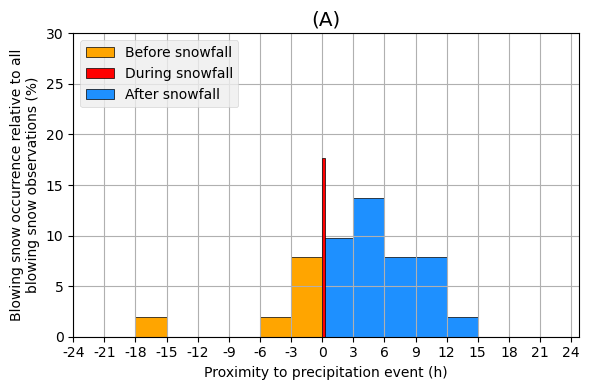

In [33]:
fig, axs = plt.subplots(figsize=(6, 4), tight_layout=True)

# change the plotstyle to ggplot
plt.style.use('bmh')
# Plot of fraction of total occurrences of blowing snow
ax = axs
bsf_percent_of_total_after = (grouped_after_bsf_sum['bsf_class']/bsf_obs)*100
bsf_percent_of_total_before = (grouped_before_bsf_sum['bsf_class'] / bsf_obs)*100

for i,v in enumerate([-1,-2,-3,-4,-5,-6,-7,-8,]):
    if i == 0:
        ax.bar(v, bsf_percent_of_total_before.values[i], color='orange', width=1, align='edge', label='Before snowfall', ec='black')
    else:
        ax.bar(v, bsf_percent_of_total_before.values[i], color='orange', width=1, align='edge', ec='black')

# add a bar for the co-occurence of blowing snow and precipitation
ax.bar(0, co_occurence_bsf*100, color='red', width=0.1, align='edge', label='During snowfall', ec='black', zorder=10)
# add bars for the time before precipitation
bsf_percent_of_total_after.plot.bar(ax=ax, align='edge', width=1, color='dodgerblue', label='After snowfall', ec='black')

ax.set_xlabel('Proximity to precipitation event (h)')
ax.set_ylabel('Blowing snow occurrence relative to all\nblowing snow observations (%)')
ax.set_title('(A)')
# set the x ticks to be every 3 hours from -24 to 24
ax.set_xticks(np.arange(-8, 9,1))
ax.set_xticklabels(np.arange(-24,26,3), rotation=0)
ax.set_ylim(0,30)
ax.legend(loc='upper left')




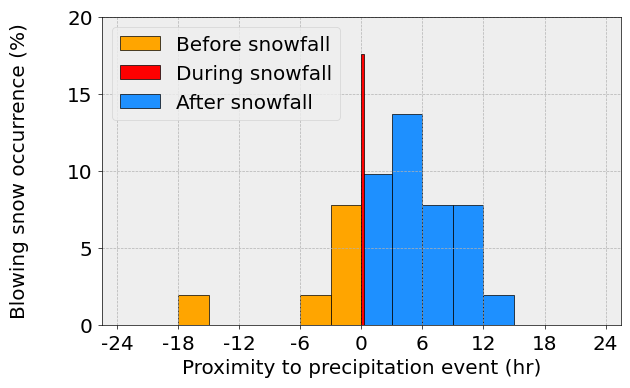

In [63]:
fontsize_scale = 1.6  # You can change this value to scale up/down

fig, axs = plt.subplots(figsize=(6.7, 4))

# change the plot style
plt.style.use('bmh')

# Plot of fraction of total occurrences of blowing snow
ax = axs
bsf_percent_of_total_after = (grouped_after_bsf_sum['bsf_class'] / bsf_obs) * 100
bsf_percent_of_total_before = (grouped_before_bsf_sum['bsf_class'] / bsf_obs) * 100

for i, v in enumerate([-1, -2, -3, -4, -5, -6, -7, -8]):
    ax.bar(
        v, bsf_percent_of_total_before.values[i],
        color='orange', width=1, align='edge',
        label='Before snowfall' if i == 0 else "",
        ec='black'
    )

# Co-occurrence bar
ax.bar(0, co_occurence_bsf * 100, color='red', width=0.1,
       align='edge', label='During snowfall', ec='black', zorder=10)

# After precipitation bars
bsf_percent_of_total_after.plot.bar(
    ax=ax, align='edge', width=1, color='dodgerblue',
    label='After snowfall', ec='black'
)

# Labels and Title
ax.set_xlabel('Proximity to precipitation event (hr)', fontsize=9 * fontsize_scale)
ax.set_ylabel("Blowing snow occurrence (%)",#'Blowing snow occurrence relative to\nall blowing snow observations (%)',
              fontsize=9 * fontsize_scale)
# ax.set_title('(A)', fontsize=12 * fontsize_scale)

# Ticks
ax.set_xticks(np.arange(-8, 9, 2))
ax.set_xticklabels(np.arange(-24, 26, 6), rotation=0, fontsize=9 * fontsize_scale)
ax.yaxis.set_tick_params(direction='out', length=3, width=0.5, labelsize=9 * fontsize_scale)
ax.xaxis.set_tick_params(direction='out', length=3, width=0.5, labelsize=9 * fontsize_scale)

# Set axis limits and legend
ax.set_ylim(0, 20)
ax.set_xlim(-8.5,8.5)
ax.legend(loc='upper left', fontsize=9 * 1.6)

# make edges of the plot black
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(0.5)

# add space betwee y-label and y-axis
ax.yaxis.set_label_coords(-0.14, 0.5)

In [114]:
bsf_percent_of_total_before.sum()

11.76470588235294

In [115]:
co_occurence_bsf

0.17647058823529413

In [ ]:
grouped_after_bsf_sum

,range,backscatter_profile,bsf,bsf_class,hours_since_precip,hours_before_precip
hours_since_precip,,,,,,
"(1, 5]",208650.0,0.0,264.640015,764,11481.250000,83785.416667
"(5, 9]",121100.0,0.0,141.350006,464,16707.666667,53829.000000
"(9, 13]",90800.0,0.0,101.580002,316,19957.333333,47527.416667
"(13, 17]",77300.0,0.0,33.980000,226,23139.083333,48070.916667
"(17, 21]",70250.0,0.0,17.299999,204,26718.250000,43891.666667
"(21, 25]",63850.0,0.0,9.070000,110,29700.583333,40180.916667
"(25, 29]",56300.0,0.0,6.310000,32,31664.666667,36506.750000
"(29, 33]",48800.0,0.0,2.340000,40,31748.333333,35916.083333
"(33, 37]",42500.0,0.0,0.840000,28,31447.583333,33691.250000


### Linear Relationships between Variables

#### Filtering days... 

with snow in the past 24 hours and days with no snow in the past 24 hours

Is the relationship between wind speed and blowing snow flux stronger if it precipitated?

#### Plotting Wind Direction

In [ ]:
# Add blowing snow flux 
max_val = sos_1H_max_wspd_ds['w_h2o__3m_uw'].mean()+(sos_1H_max_wspd_ds['w_h2o__3m_uw'].std()*3)
min_val = sos_1H_max_wspd_ds['w_h2o__3m_uw'].mean()-(sos_1H_max_wspd_ds['w_h2o__3m_uw'].std()*3)
sos_1H_max_wspd_ds['bsf'] = np.log(sos_1H_max_wspd_ds['SF_avg_1m_ue']+sos_1H_max_wspd_ds['SF_avg_2m_ue']).where(sos_1H_max_wspd_ds['SF_avg_1m_ue']+sos_1H_max_wspd_ds['SF_avg_2m_ue']>0.001)
# Filter
filtered_ds = sos_1H_max_wspd_ds.where((sos_1H_max_wspd_ds['w_h2o__3m_uw']<max_val) &
                                          (sos_1H_max_wspd_ds['w_h2o__3m_uw']>min_val)
                                            #  (sos_1H_max_wspd_ds['spd_10m_ue']>=5)
                                          )

binary_23_daily_df = binary_23_df.resample('1D').sum()
binary_23_3D_df = binary_23_df.resample('3D').sum()
# if precip binary is > 1, set to 1
binary_23_daily_df = binary_23_daily_df.apply(lambda x: 1 if x > 3 else 0)
binary_23_3D_df = binary_23_3D_df.apply(lambda x: 1 if x > 3 else 0)
binary_23_hourly_df = binary_23_daily_df.resample('1H').ffill()
binary_23_3D_hourly_df = binary_23_3D_df.resample('1H').ffill()

start_date = '2023-03-01'
end_date = '2023-03-31'
# add to the ds 
sos_1H_max_wspd_no_prcp = filtered_ds.sel(time=binary_23_df.iloc[:-7][binary_23_df==0].index).sel(time=slice(start_date, end_date))
sos_1H_max_wspd_prcp = filtered_ds.sel(time=binary_23_df.iloc[:-7][binary_23_df==1].index).sel(time=slice(start_date, end_date))
sos_1H_max_wspd_no_1D_prcp = filtered_ds.sel(time=binary_23_hourly_df.iloc[:-7][binary_23_hourly_df==0].index).sel(time=slice(start_date, end_date))
sos_1H_max_wspd_3D_prcp = filtered_ds.sel(time=binary_23_3D_hourly_df.iloc[:-7][binary_23_3D_hourly_df==0].index).sel(time=slice(start_date, end_date))

def create_linreg(ds, x, y):
   tmp_ds = ds[[x,y]].dropna(dim='time')  
   slope, intercept, r,_,_ = stats.linregress(tmp_ds[x],tmp_ds[y])
   x_pred = np.array([tmp_ds[x].min(), tmp_ds[x].max()])
   y_pred = slope*x_pred + intercept
   return x_pred, y_pred, round(r**2,2)
if sos_1H_max_wspd_3D_prcp.time.size == 0:
   skip = True
else:
    skip = False 
    
# create linear regression for each dataset
x1, fit_1, r2_1 = create_linreg(sos_1H_max_wspd_no_prcp, 'spd_10m_ue', 'bsf')
x2, fit_2, r2_2 = create_linreg(sos_1H_max_wspd_prcp, 'spd_10m_ue', 'bsf')
x3, fit_3, r2_3 = create_linreg(sos_1H_max_wspd_no_1D_prcp, 'spd_10m_ue', 'bsf')
if not skip:
    x4, fit_4, r2_4 = create_linreg(sos_1H_max_wspd_3D_prcp, 'spd_10m_ue', 'bsf')
else:
    r2_4 = 'NaN'
    
if plot_plotly_figs:
    # make a plotly plot with 2 rows and 2 columns
    fig = make_subplots(rows=2, cols=2, shared_xaxes=True, shared_yaxes=True, vertical_spacing=0.1,
                        subplot_titles=(f"Periods with No Precipitation - R2={r2_1}", 
                                        f"Periods with Precipitation - R2={r2_2}",
                                        f"Periods with No Precipitation<br>for previous 24 Hours - R2={r2_3}", 
                                        f"Periods with No Precipitation<br>for previous 72 Hours - R2={r2_4}"))

    # add the first plot
    fig.add_trace(go.Scatter(x=sos_1H_max_wspd_no_prcp.spd_10m_ue,
                            y=sos_1H_max_wspd_no_prcp.bsf,
                            mode='markers',
                            marker=dict(size=10,
                                        color=sos_1H_max_wspd_no_prcp.dir_10m_ue, #set color equal to a variable
                                        colorscale='twilight_r', # one of plotly colorscales
                                        showscale=True),
                            name='Blowing Snow Flux',
                            showlegend=False,
                            ),
                            row=1, col=1)
    fig.add_trace(go.Scatter(x=x1, 
                            y=fit_1, 
                            mode='lines', 
                            name='Linear Regression', 
                            showlegend=False),
                            row=1, col=1)
    # add hover with r2_1
    fig.update_traces(
        hovertemplate="<br>".join([
            f"R2: {r2_1}",
        ]), col=1, row=1
    )

    # add the second plot
    fig.add_trace(go.Scatter(x=sos_1H_max_wspd_prcp.spd_10m_ue,
                            y=sos_1H_max_wspd_prcp.bsf,
                            mode='markers',
                            marker=dict(size=10,
                                        color=sos_1H_max_wspd_prcp.dir_10m_ue, #set color equal to a variable
                                        colorscale='twilight_r', # one of plotly colorscales
                                        showscale=False),
                            showlegend=False),
                            row=1, col=2)
    fig.add_trace(go.Scatter(x=x2, 
                            y=fit_2, 
                            mode='lines', 
                            name='Linear Regression', 
                            showlegend=False),
                            row=1, col=2)
    # add hover with r2_1
    fig.update_traces(
        hovertemplate="<br>".join([
            f"R2: {r2_2}",
        ]), col=2, row=1
    )


    # add the third plot
    fig.add_trace(go.Scatter(x=sos_1H_max_wspd_no_1D_prcp.spd_10m_ue,
                            y=sos_1H_max_wspd_no_1D_prcp.bsf,
                            mode='markers',
                            marker=dict(size=10,
                                        color=sos_1H_max_wspd_no_1D_prcp.dir_10m_ue, #set color equal to a variable
                                        colorscale='twilight_r', # one of plotly colorscales
                                        showscale=False),
                            showlegend=False),
                            row=2, col=1)
    fig.add_trace(go.Scatter(x=x3, 
                            y=fit_3, 
                            mode='lines', 
                            name='Linear Regression', 
                            showlegend=False),
                            row=2, col=1)
    # add hover with r2_1
    fig.update_traces(
        hovertemplate="<br>".join([
            f"R2: {r2_3}",
        ]), col=1, row=2
    )
                            
    if not skip:
        # add the fourth plot
        fig.add_trace(go.Scatter(x=sos_1H_max_wspd_3D_prcp.spd_10m_ue,
                                y=sos_1H_max_wspd_3D_prcp.bsf,
                                mode='markers',
                                marker=dict(size=10,
                                            color=sos_1H_max_wspd_3D_prcp.dir_10m_ue, #set color equal to a variable
                                            colorscale='twilight_r', # one of plotly colorscales
                                            showscale=False),
                                showlegend=False),
                                row=2, col=2,)
        fig.add_trace(go.Scatter(x=x4, 
                                y=fit_4, 
                                mode='lines', 
                                name='Linear Regression', 
                                showlegend=False),
                                row=2, col=2)
        # add hover with r2_1
        fig.update_traces(marker_line_width=1,
                        marker_line_color="black",
                        hovertemplate="<br>".join([f"R2: {r2_4}",]), 
                        col=2, row=2)                                         

    # format the size, axis titles, and subplot titles
    fig.update_layout(height=800,
                    width=800,
                    title_text=f"Hourly Blowing Snow Flux vs. Max Wind Speed<br>{start_date} - {end_date}",
                    xaxis3_title="Wind Speed (m/s)",
                    xaxis4_title="Wind Speed (m/s)",
                    yaxis_title="Blowing Snow Flux",
                    yaxis3_title="Blowing Snow Flux",
                    coloraxis_colorbar=dict(
                    title="Wind Direction (deg&;)"),
    )
    fig.update_traces(marker_line_width=1,
                    marker_line_color="black")
    fig.update_xaxes(title_font_size=20)
    fig.update_yaxes(title_font_size=20, range=[-7,1])


#### Plotting 3m C temperature

In [ ]:
# Add blowing snow flux 
max_val = sos_1H_max_wspd_ds['w_h2o__3m_uw'].mean()+(sos_1H_max_wspd_ds['w_h2o__3m_uw'].std()*3)
min_val = sos_1H_max_wspd_ds['w_h2o__3m_uw'].mean()-(sos_1H_max_wspd_ds['w_h2o__3m_uw'].std()*3)
sos_1H_max_wspd_ds['bsf'] = np.log(sos_1H_max_wspd_ds['SF_avg_1m_ue']+sos_1H_max_wspd_ds['SF_avg_2m_ue']).where(sos_1H_max_wspd_ds['SF_avg_1m_ue']+sos_1H_max_wspd_ds['SF_avg_2m_ue']>0.001)
# Filter
filtered_ds = sos_1H_max_wspd_ds.where((sos_1H_max_wspd_ds['w_h2o__3m_uw']<max_val) &
                                          (sos_1H_max_wspd_ds['w_h2o__3m_uw']>min_val)
                                            #  (sos_1H_max_wspd_ds['spd_10m_ue']>=5)
                                          )

binary_23_daily_df = binary_23_df.resample('1D').sum()
binary_23_3D_df = binary_23_df.resample('3D').sum()
# if precip binary is > 1, set to 1
binary_23_daily_df = binary_23_daily_df.apply(lambda x: 1 if x > 3 else 0)
binary_23_3D_df = binary_23_3D_df.apply(lambda x: 1 if x > 3 else 0)
binary_23_hourly_df = binary_23_daily_df.resample('1H').ffill()
binary_23_3D_hourly_df = binary_23_3D_df.resample('1H').ffill()

start_date = '2022-12-01'
end_date = '2022-12-31'
# add to the ds 
sos_1H_max_wspd_no_prcp = filtered_ds.sel(time=binary_23_df.iloc[:-7][binary_23_df==0].index).sel(time=slice(start_date, end_date))
sos_1H_max_wspd_prcp = filtered_ds.sel(time=binary_23_df.iloc[:-7][binary_23_df==1].index).sel(time=slice(start_date, end_date))
sos_1H_max_wspd_no_1D_prcp = filtered_ds.sel(time=binary_23_hourly_df.iloc[:-7][binary_23_hourly_df==0].index).sel(time=slice(start_date, end_date))
sos_1H_max_wspd_3D_prcp = filtered_ds.sel(time=binary_23_3D_hourly_df.iloc[:-7][binary_23_3D_hourly_df==0].index).sel(time=slice(start_date, end_date))

if sos_1H_max_wspd_3D_prcp.time.size == 0:
   skip = True
else:
    skip = False
def create_linreg(ds, x, y):
   tmp_ds = ds[[x,y]].dropna(dim='time')  
   slope, intercept, r,_,_ = stats.linregress(tmp_ds[x],tmp_ds[y])
   x_pred = np.array([tmp_ds[x].min(), tmp_ds[x].max()])
   y_pred = slope*x_pred + intercept
   return x_pred, y_pred, round(r**2,2)

# create linear regression for each dataset
x1, fit_1, r2_1 = create_linreg(sos_1H_max_wspd_no_prcp, 'spd_10m_ue', 'bsf')
x2, fit_2, r2_2 = create_linreg(sos_1H_max_wspd_prcp, 'spd_10m_ue', 'bsf')
x3, fit_3, r2_3 = create_linreg(sos_1H_max_wspd_no_1D_prcp, 'spd_10m_ue', 'bsf')
if not skip:
    x4, fit_4, r2_4 = create_linreg(sos_1H_max_wspd_3D_prcp, 'spd_10m_ue', 'bsf')

if plot_plotly_figs:
    # make a plotly plot with 2 rows and 2 columns
    fig = make_subplots(rows=2, cols=2, shared_xaxes=True, shared_yaxes=True, vertical_spacing=0.1,
                        subplot_titles=(f"Periods with No Precipitation - R2={r2_1}", 
                                        f"Periods with Precipitation - R2={r2_2}",
                                        f"Periods with No Precipitation<br>for previous 24 Hours - R2={r2_3}", 
                                        f"Periods with No Precipitation<br>for previous 72 Hours - R2={r2_4}"))

    # add the first plot
    fig.add_trace(go.Scatter(x=sos_1H_max_wspd_no_prcp.spd_10m_ue,
                            y=sos_1H_max_wspd_no_prcp.bsf,
                            mode='markers',
                            marker=dict(size=10,
                                        color=sos_1H_max_wspd_no_prcp.T_3m_c, #set color equal to a variable
                                        colorscale='viridis', # one of plotly colorscales
                                        cmin=-12,
                                        cmax=0,
                                        showscale=True),
                            name='Blowing Snow Flux',
                            showlegend=False,
                            ),
                            row=1, col=1)
    fig.add_trace(go.Scatter(x=x1, 
                            y=fit_1, 
                            mode='lines', 
                            name='Linear Regression', 
                            showlegend=False),
                            row=1, col=1)
    # add hover with r2_1
    fig.update_traces(
        hovertemplate="<br>".join([
            f"R2: {r2_1}",
        ]), col=1, row=1
    )

    # add the second plot
    fig.add_trace(go.Scatter(x=sos_1H_max_wspd_prcp.spd_10m_ue,
                            y=sos_1H_max_wspd_prcp.bsf,
                            mode='markers',
                            marker=dict(size=10,
                                        color=sos_1H_max_wspd_prcp.T_3m_c, #set color equal to a variable
                                        colorscale='viridis', # one of plotly colorscales
                                        cmin=-12,
                                        cmax=0,
                                        showscale=False),
                            showlegend=False),
                            row=1, col=2)
    fig.add_trace(go.Scatter(x=x2, 
                            y=fit_2, 
                            mode='lines', 
                            name='Linear Regression', 
                            showlegend=False),
                            row=1, col=2)
    # add hover with r2_1
    fig.update_traces(
        hovertemplate="<br>".join([
            f"R2: {r2_2}",
        ]), col=2, row=1
    )


    # add the third plot
    fig.add_trace(go.Scatter(x=sos_1H_max_wspd_no_1D_prcp.spd_10m_ue,
                            y=sos_1H_max_wspd_no_1D_prcp.bsf,
                            mode='markers',
                            marker=dict(size=10,
                                        color=sos_1H_max_wspd_no_1D_prcp.T_3m_c, #set color equal to a variable
                                        colorscale='viridis', # one of plotly colorscales
                                        cmin=-12,
                                        cmax=0,
                                        showscale=False),
                            showlegend=False),
                            row=2, col=1)
    fig.add_trace(go.Scatter(x=x3, 
                            y=fit_3, 
                            mode='lines', 
                            name='Linear Regression', 
                            showlegend=False),
                            row=2, col=1)
    # add hover with r2_1
    fig.update_traces(
        hovertemplate="<br>".join([
            f"R2: {r2_3}",
        ]), col=1, row=2
    )                         
    if not skip:
        # add the fourth plot
        fig.add_trace(go.Scatter(x=sos_1H_max_wspd_3D_prcp.spd_10m_ue,
                                y=sos_1H_max_wspd_3D_prcp.bsf,
                                mode='markers',
                                marker=dict(size=10,
                                            color=sos_1H_max_wspd_3D_prcp.T_3m_c, #set color equal to a variable
                                            colorscale='viridis', # one of plotly colorscales
                                            cmin=-12,
                                            cmax=0,
                                            showscale=False),
                                showlegend=False),
                                row=2, col=2,)
        fig.add_trace(go.Scatter(x=x4, 
                                y=fit_4, 
                                mode='lines', 
                                name='Linear Regression', 
                                showlegend=False),
                                row=2, col=2)
        # add hover with r2_1
        fig.update_traces(marker_line_width=1,
                        marker_line_color="black",
                        hovertemplate="<br>".join([f"R2: {r2_4}",]), 
                        col=2, row=2)                                         

    # format the size, axis titles, and subplot titles
    fig.update_layout(height=800,
                    width=800,
                    title_text=f"Hourly log(Blowing Snow Flux) vs. Max Wind Speed<br>{start_date} - {end_date}",
                    xaxis3_title="Wind Speed (m/s)",
                    xaxis4_title="Wind Speed (m/s)",
                    yaxis_title="log(Blowing Snow Flux)",
                    yaxis3_title="log(Blowing Snow Flux)",
                    coloraxis_colorbar=dict(
                    title="Wind Direction (deg&;)"),
    )
    fig.update_traces(marker_line_width=1,
                    marker_line_color="black")
    fig.update_xaxes(title_font_size=20)
    fig.update_yaxes(title_font_size=20, range=[-7,1])


#### Heatmaps Precipitation with Wind Speed and Direction

In [ ]:
# function for prepping the data
def make_heatmap_df(ds, location, campaign, year, max_spd=False, precip_var='precip_rate'):
    if campaign == 'sail':
        if location =='gts':
            if max_spd == True:
                wspd_var = 'wspd_max'
                wdir_var = 'wdir_max'
            else:
                wspd_var = 'wspd_arith_mean'
                wdir_var = 'wdir_vec_mean'
            title = 'Gothic'
        elif location == 'kp':
            wspd_var = 'wind_spd'
            wdir_var = 'wind_dir'
            title = 'Kettle Ponds'
    elif campaign =='sos':
        if max_spd == True:
            wspd_var = 'wspd_max'
            wdir_var = 'wdir_max'
        else:
            wspd_var = 'spd_10m_uw'
            wdir_var = 'dir_10m_uw'
        temp_var = 'T_3m_c'
        title = 'Kettle Ponds'
    else:
        if max_spd == True:
            wspd_var = 'wspd_max'
            wdir_var = 'wdir_max'
        else:
            wspd_var = 'wspd_vec_mean'
            wdir_var = 'wdir_vec_mean'
        temp_var = 'temp'
        if location == 'kp':
            title = 'Kettle Ponds'
        else: title = 'Avery Picnic'
    precip_var = 'precip_rate'
    df_to_use = ds.to_dataframe()
    df_test = df_to_use[[wspd_var, wdir_var, precip_var]]

    # wind speed bins
    wspd_bins = [0, 2, 4, 6, 8, 10,]
    # wind direction bins
    wdir_bins = [0, 45, 90, 135, 180, 225, 270, 315, 360]

    # wspd cut and sum sublimation for each bin
    wsp_assignment = pd.cut(df_test[wspd_var], bins=wspd_bins, labels=wspd_bins[:-1])
    wsp_assignment.name = 'wsp_assignment'
    # wdir cut and sum sublimation for each bin
    wdir_assignment = pd.cut(df_test[wdir_var], bins=wdir_bins, labels=wdir_bins[:-1])
    wdir_assignment.name = 'wdir_assignment'

    # combine the two assignments and the sublimation
    df_test['wsp_assignment'] = wsp_assignment.values
    df_test['wdir_assignment'] = wdir_assignment.values

    # groupby the wspd and wdir assignments and get the sum of w_h2o__3m_uw
    grouped = df_test.groupby(['wsp_assignment', 'wdir_assignment']).sum()[precip_var]
    # unstack and put into a dataframe
    grouped =(grouped.unstack())
    grouped = 100*(grouped/(grouped.sum().sum()))

    # plot grouped as a heatmap
    fig = go.Figure()
    fig.add_trace(go.Heatmap(z=grouped.values, 
                            x=grouped.columns, 
                            y=grouped.index,

                            colorbar={'title':'% of total <br>precipitation'},
                            colorscale='Blues',
                            # min and max color values
                            zmin=0,
                            zmax=20,
                            xgap=1,
                            ygap=1,
                            ))
    # add grid
    fig.update_layout(height=400, 
                    width=600,
                    xaxis_title='Wind Direction',
                    yaxis_title='Wind Speed',
                    title=f'Wind Speed and Wind Direction with Precipitation<br> for {campaign.upper()} in {year} at {title}',
                    )
    # change x-axis ticks to be cardinal wind directions
    fig.update_xaxes(tickvals=[0, 45, 90, 135, 180, 225, 270, 315], ticktext=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    # update y-axes ticks to be wind speed bins
    fig.update_yaxes(tickvals=[0, 2, 4, 6, 8, 10, 12, 14, 16, 18], ticktext=['0-2', '2-4', '4-6', '6-8', '8-10', '10-12', '12-14', '14-16', '16-18', '18-20'])
    # save the figure as a png
    pio.write_image(fig,f'./04_products/figures/sandbox/{campaign}_{location}_{year}_ppt_winds.png', scale=8)
    return fig


##### 2022 figures

In [ ]:
make_heatmap_df(w22_sail_met_qc_ds_1H, 
                location='gts',
                campaign = 'sail',
                year='2022')

# update legend title to legend_title='Percent of Winter Sublimation (%)'

In [ ]:
# plotly radar plot using wind direction and percent of total precipitation
df = w22_sail_met_qc_ds_1H[['precip_rate','wdir_vec_mean']].to_dataframe()
# create precipitation binary
df['precip_binary'] = df['precip_rate'].apply(lambda x: 1 if x > 0 else 0)
# total amount of precipitation in each bin
grouped_df_sum = df.groupby(pd.cut(df['wdir_vec_mean'], bins=np.arange(0, 361, 45))).sum()
# total number of observations in each bin
grouped_df_count = df.groupby(pd.cut(df['wdir_vec_mean'], bins=np.arange(0, 361, 45))).count()['wdir_vec_mean']

# percent of total precipitation in each bin
grouped_df_percent = 100*(grouped_df_sum['precip_rate'] / grouped_df_sum['precip_rate'].sum()).to_frame()

# change out the index to be the cardinal wind directions
grouped_df_percent.index = [0,45, 90, 135, 180, 225, 270, 315,]
# add the first value again
grouped_df_percent.loc[360] = grouped_df_percent.loc[0].values

# normalized each bins precipitation by the number of observations in each bin
grouped_df_percent_norm = 100*(grouped_df_sum['precip_binary'] / grouped_df_count)
# change out the index to be the cardinal wind directions
grouped_df_percent_norm.index = [0,45, 90, 135, 180, 225, 270, 315,]
# add the first value again
grouped_df_percent_norm.loc[360] = grouped_df_percent_norm.loc[0]

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    name='Percent of precipitation',
    r= grouped_df_percent.values.flatten(),
    theta= grouped_df_percent.index,
    fill='toself',
)
)

fig.add_trace(go.Scatterpolar(
    name='Percent of precipitation<br>normalized by observations',
    r= grouped_df_percent_norm.values.flatten(),
    theta= grouped_df_percent_norm.index,
    fill='toself',
)
)
fig.update_legends(
    yanchor="bottom",
    xanchor="center",
    x=0.99,
    y=0.95

)
fig.update_layout(
    showlegend=True,
    polar=dict(
        radialaxis_tickfont_size=12,
        radialaxis_range=[0, 75],
        angularaxis=dict(
            tickmode='array',
            tickvals=[0, 45, 90, 135, 180, 225, 270, 315],
            ticktext=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'],
            rotation=90,
            direction='clockwise'
        )),
        width=600,
        height=600,
        title='SAIL 2022 Winter Precipitation by Wind Direction')



In [ ]:
make_heatmap_df(w22_splash_ap_qc_ds_1H, 
                location='ap',
                campaign = 'splash',
                year='2022')

# update legend title to legend_title='Percent of Winter Sublimation (%)'

In [ ]:
# plotly radar plot using wind direction and percent of total precipitation
df = w22_splash_ap_qc_ds_1H[['precip_rate','wdir_vec_mean']].to_dataframe()
# create precipitation binary
df['precip_binary'] = df['precip_rate'].apply(lambda x: 1 if x > 0 else 0)
# total amount of precipitation in each bin
grouped_df_sum = df.groupby(pd.cut(df['wdir_vec_mean'], bins=np.arange(0, 361, 45))).sum()
# total number of observations in each bin
grouped_df_count = df.groupby(pd.cut(df['wdir_vec_mean'], bins=np.arange(0, 361, 45))).count()['wdir_vec_mean']

# percent of total precipitation in each bin
grouped_df_percent = 100*(grouped_df_sum['precip_rate'] / grouped_df_sum['precip_rate'].sum()).to_frame()

# change out the index to be the cardinal wind directions
grouped_df_percent.index = [0,45, 90, 135, 180, 225, 270, 315,]
# add the first value again
grouped_df_percent.loc[360] = grouped_df_percent.loc[0].values

# normalized each bins precipitation by the number of observations in each bin
grouped_df_percent_norm = 100*(grouped_df_sum['precip_binary'] / grouped_df_count)
# change out the index to be the cardinal wind directions
grouped_df_percent_norm.index = [0,45, 90, 135, 180, 225, 270, 315,]
# add the first value again
grouped_df_percent_norm.loc[360] = grouped_df_percent_norm.loc[0]

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    name='Percent of precipitation',
    r= grouped_df_percent.values.flatten(),
    theta= grouped_df_percent.index,
    fill='toself',
)
)

fig.add_trace(go.Scatterpolar(
    name='Percent of precipitation<br>normalized by observations',
    r= grouped_df_percent_norm.values.flatten(),
    theta= grouped_df_percent_norm.index,
    fill='toself',
)
)
fig.update_legends(
    yanchor="bottom",
    xanchor="center",
    x=0.99,
    y=0.95

)
fig.update_layout(
    showlegend=True,
    polar=dict(
        radialaxis_tickfont_size=12,
        radialaxis_range=[0, 75],
        angularaxis=dict(
            tickmode='array',
            tickvals=[0, 45, 90, 135, 180, 225, 270, 315],
            ticktext=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'],
            rotation=90,
            direction='clockwise'
        )),
        width=600,
        height=600,
        title='SPLASH - AP 2022 Winter Precipitation by Wind Direction')



In [ ]:
make_heatmap_df(w22_splash_kp_qc_ds_1H, 
                location='kp',
                campaign = 'splash',
                year='2022')

In [ ]:
# plotly radar plot using wind direction and percent of total precipitation
df = w22_splash_kp_qc_ds_1H[['precip_rate','wdir_vec_mean']].to_dataframe()
# create precipitation binary
df['precip_binary'] = df['precip_rate'].apply(lambda x: 1 if x > 0 else 0)
# total amount of precipitation in each bin
grouped_df_sum = df.groupby(pd.cut(df['wdir_vec_mean'], bins=np.arange(0, 361, 45))).sum()
# total number of observations in each bin
grouped_df_count = df.groupby(pd.cut(df['wdir_vec_mean'], bins=np.arange(0, 361, 45))).count()['wdir_vec_mean']

# percent of total precipitation in each bin
grouped_df_percent = 100*(grouped_df_sum['precip_rate'] / grouped_df_sum['precip_rate'].sum()).to_frame()

# change out the index to be the cardinal wind directions
grouped_df_percent.index = [0,45, 90, 135, 180, 225, 270, 315,]
# add the first value again
grouped_df_percent.loc[360] = grouped_df_percent.loc[0].values

# normalized each bins precipitation by the number of observations in each bin
grouped_df_percent_norm = 100*(grouped_df_sum['precip_binary'] / grouped_df_count)
# change out the index to be the cardinal wind directions
grouped_df_percent_norm.index = [0,45, 90, 135, 180, 225, 270, 315,]
# add the first value again
grouped_df_percent_norm.loc[360] = grouped_df_percent_norm.loc[0]

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    name='Percent of precipitation',
    r= grouped_df_percent.values.flatten(),
    theta= grouped_df_percent.index,
    fill='toself',
)
)

fig.add_trace(go.Scatterpolar(
    name='Percent of precipitation<br>normalized by observations',
    r= grouped_df_percent_norm.values.flatten(),
    theta= grouped_df_percent_norm.index,
    fill='toself',
)
)
fig.update_legends(
    yanchor="bottom",
    xanchor="center",
    x=0.99,
    y=0.95

)
fig.update_layout(
    showlegend=True,
    polar=dict(
        radialaxis_tickfont_size=12,
        radialaxis_range=[0, 75],
        angularaxis=dict(
            tickmode='array',
            tickvals=[0, 45, 90, 135, 180, 225, 270, 315],
            ticktext=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'],
            rotation=90,
            direction='clockwise'
        )),
        width=600,
        height=600,
        title='SPLASH - KP 2022 Winter Precipitation by Wind Direction')



##### 2023 figures

In [ ]:
make_heatmap_df(w23_splash_ap_qc_ds_1H, 
                location='ap',
                campaign = 'splash',
                year='2023',
                precip_var='precip_rate_tilden')

In [ ]:
# plotly radar plot using wind direction and percent of total precipitation
df = w23_splash_ap_qc_ds_1H[['precip_rate','wdir_vec_mean']].to_dataframe()
# create precipitation binary
df['precip_binary'] = df['precip_rate'].apply(lambda x: 1 if x > 0 else 0)
# total amount of precipitation in each bin
grouped_df_sum = df.groupby(pd.cut(df['wdir_vec_mean'], bins=np.arange(0, 361, 45))).sum()
# total number of observations in each bin
grouped_df_count = df.groupby(pd.cut(df['wdir_vec_mean'], bins=np.arange(0, 361, 45))).count()['wdir_vec_mean']

# percent of total precipitation in each bin
grouped_df_percent = 100*(grouped_df_sum['precip_rate'] / grouped_df_sum['precip_rate'].sum()).to_frame()

# change out the index to be the cardinal wind directions
grouped_df_percent.index = [0,45, 90, 135, 180, 225, 270, 315,]
# add the first value again
grouped_df_percent.loc[360] = grouped_df_percent.loc[0].values

# normalized each bins precipitation by the number of observations in each bin
grouped_df_percent_norm = 100*(grouped_df_sum['precip_binary'] / grouped_df_count)
# change out the index to be the cardinal wind directions
grouped_df_percent_norm.index = [0,45, 90, 135, 180, 225, 270, 315,]
# add the first value again
grouped_df_percent_norm.loc[360] = grouped_df_percent_norm.loc[0]

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    name='Percent of precipitation',
    r= grouped_df_percent.values.flatten(),
    theta= grouped_df_percent.index,
    fill='toself',
)
)

fig.add_trace(go.Scatterpolar(
    name='Percent of precipitation<br>normalized by observations',
    r= grouped_df_percent_norm.values.flatten(),
    theta= grouped_df_percent_norm.index,
    fill='toself',
)
)
fig.update_legends(
    yanchor="bottom",
    xanchor="center",
    x=0.99,
    y=0.95

)
fig.update_layout(
    showlegend=True,
    polar=dict(
        radialaxis_tickfont_size=12,
        radialaxis_range=[0, 75],
        angularaxis=dict(
            tickmode='array',
            tickvals=[0, 45, 90, 135, 180, 225, 270, 315],
            ticktext=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'],
            rotation=90,
            direction='clockwise'
        )),
        width=600,
        height=600,
        title='SPLASH - AP 2022 Winter Precipitation by Wind Direction')



In [ ]:
make_heatmap_df(w23_splash_kp_qc_ds_1H, 
                location='kp',
                campaign = 'splash',
                year='2023',
                precip_var='precip_rate_tilden')

In [ ]:
# plotly radar plot using wind direction and percent of total precipitation
df = w23_splash_kp_qc_ds_1H[['precip_rate','wdir_vec_mean']].to_dataframe()
# create precipitation binary
df['precip_binary'] = df['precip_rate'].apply(lambda x: 1 if x > 0 else 0)
# total amount of precipitation in each bin
grouped_df_sum = df.groupby(pd.cut(df['wdir_vec_mean'], bins=np.arange(0, 361, 45))).sum()
# total number of observations in each bin
grouped_df_count = df.groupby(pd.cut(df['wdir_vec_mean'], bins=np.arange(0, 361, 45))).count()['wdir_vec_mean']

# percent of total precipitation in each bin
grouped_df_percent = 100*(grouped_df_sum['precip_rate'] / grouped_df_sum['precip_rate'].sum()).to_frame()

# change out the index to be the cardinal wind directions
grouped_df_percent.index = [0,45, 90, 135, 180, 225, 270, 315,]
# add the first value again
grouped_df_percent.loc[360] = grouped_df_percent.loc[0].values

# normalized each bins precipitation by the number of observations in each bin
grouped_df_percent_norm = 100*(grouped_df_sum['precip_binary'] / grouped_df_count)
# change out the index to be the cardinal wind directions
grouped_df_percent_norm.index = [0,45, 90, 135, 180, 225, 270, 315,]
# add the first value again
grouped_df_percent_norm.loc[360] = grouped_df_percent_norm.loc[0]

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    name='Percent of precipitation',
    r= grouped_df_percent.values.flatten(),
    theta= grouped_df_percent.index,
    fill='toself',
)
)

fig.add_trace(go.Scatterpolar(
    name='Percent of precipitation<br>normalized by observations',
    r= grouped_df_percent_norm.values.flatten(),
    theta= grouped_df_percent_norm.index,
    fill='toself',
)
)
fig.update_legends(
    yanchor="bottom",
    xanchor="center",
    x=0.99,
    y=0.95

)
fig.update_layout(
    showlegend=True,
    polar=dict(
        radialaxis_tickfont_size=12,
        radialaxis_range=[0, 75],
        angularaxis=dict(
            tickmode='array',
            tickvals=[0, 45, 90, 135, 180, 225, 270, 315],
            ticktext=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'],
            rotation=90,
            direction='clockwise'
        )),
        width=600,
        height=600,
        title='SPLASH - KP 2023 Winter Precipitation by Wind Direction')



In [ ]:
make_heatmap_df(sos_1H_mean_wspd_ds, 
                location='kp',
                campaign = 'sos',
                year='2023',
                precip_var = 'precip_rate')

In [ ]:
# plotly radar plot using wind direction and percent of total precipitation
df = sos_1H_mean_wspd_ds[['precip_rate','dir_10m_uw']].to_dataframe()
# create precipitation binary
df['precip_binary'] = df['precip_rate'].apply(lambda x: 1 if x > 0 else 0)
# total amount of precipitation in each bin
grouped_df_sum = df.groupby(pd.cut(df['dir_10m_uw'], bins=np.arange(0, 361, 45))).sum()
# total number of observations in each bin
grouped_df_count = df.groupby(pd.cut(df['dir_10m_uw'], bins=np.arange(0, 361, 45))).count()['dir_10m_uw']

# percent of total precipitation in each bin
grouped_df_percent = 100*(grouped_df_sum['precip_rate'] / grouped_df_sum['precip_rate'].sum()).to_frame()

# change out the index to be the cardinal wind directions
grouped_df_percent.index = [0,45, 90, 135, 180, 225, 270, 315,]
# add the first value again
grouped_df_percent.loc[360] = grouped_df_percent.loc[0].values

# normalized each bins precipitation by the number of observations in each bin
grouped_df_percent_norm = 100*(grouped_df_sum['precip_binary'] / grouped_df_count)
# change out the index to be the cardinal wind directions
grouped_df_percent_norm.index = [0,45, 90, 135, 180, 225, 270, 315,]
# add the first value again
grouped_df_percent_norm.loc[360] = grouped_df_percent_norm.loc[0]

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    name='Percent of precipitation',
    r= grouped_df_percent.values.flatten(),
    theta= grouped_df_percent.index,
    fill='toself',
)
)

fig.add_trace(go.Scatterpolar(
    name='Percent of precipitation<br>normalized by observations',
    r= grouped_df_percent_norm.values.flatten(),
    theta= grouped_df_percent_norm.index,
    fill='toself',
)
)
fig.update_legends(
    yanchor="bottom",
    xanchor="center",
    x=0.99,
    y=0.95

)
fig.update_layout(
    showlegend=True,
    polar=dict(
        radialaxis_tickfont_size=12,
        radialaxis_range=[0, 75],
        angularaxis=dict(
            tickmode='array',
            tickvals=[0, 45, 90, 135, 180, 225, 270, 315],
            ticktext=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'],
            rotation=90,
            direction='clockwise'
        )),
        width=600,
        height=600,
        title='SOS 2023 Winter Precipitation by Wind Direction')



In [ ]:
make_heatmap_df(w23_sail_kp_qc_ds_1H, 
                location='kp',
                campaign = 'sail',
                year='2023',
                precip_var = 'precip_rate')


In [ ]:
# plotly radar plot using wind direction and percent of total precipitation
df = w23_sail_kp_qc_ds_1H[['precip_rate','wind_dir','sublimation']].to_dataframe()
# create precipitation binary
df['precip_binary'] = df['precip_rate'].apply(lambda x: 1 if x > 0 else 0)
# total amount of precipitation in each bin
grouped_df_sum = df.groupby(pd.cut(df['wind_dir'], bins=np.arange(0, 361, 45))).sum()
# total number of observations in each bin
grouped_df_count = df.groupby(pd.cut(df['wind_dir'], bins=np.arange(0, 361, 45))).count()['wind_dir']

# percent of total precipitation in each bin
grouped_df_percent = 100*(grouped_df_sum['precip_rate'] / grouped_df_sum['precip_rate'].sum()).to_frame()
grouped_df_percent_sublimation = 100*(grouped_df_sum['sublimation'] / grouped_df_sum['sublimation'].sum()).to_frame()

# change out the index to be the cardinal wind directions
grouped_df_percent.index = [0,45, 90, 135, 180, 225, 270, 315,]
# add the first value again
grouped_df_percent.loc[360] = grouped_df_percent.loc[0].values

# change out the index to be the cardinal wind directions
grouped_df_percent_sublimation.index = [0,45, 90, 135, 180, 225, 270, 315,]
# add the first value again
grouped_df_percent_sublimation.loc[360] = grouped_df_percent_sublimation.loc[0].values



fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    name='Percent of precipitation',
    r= grouped_df_percent.values.flatten(),
    theta= grouped_df_percent.index,
    fill='toself',
)
)

fig.add_trace(go.Scatterpolar(
    name='Percent of sublimation',
    r= grouped_df_percent_sublimation.values.flatten(),
    theta= grouped_df_percent_sublimation.index,
    fill='toself',
)
)


fig.update_legends(
    yanchor="bottom",
    xanchor="center",
    x=0.99,
    y=0.95

)
fig.update_layout(
    showlegend=True,
    polar=dict(
        radialaxis_tickfont_size=12,
        radialaxis_range=[0, 75],
        angularaxis=dict(
            tickmode='array',
            tickvals=[0, 45, 90, 135, 180, 225, 270, 315],
            ticktext=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'],
            rotation=90,
            direction='clockwise'
        )),
        width=600,
        height=600,
        title='SAIL 2023 Winter Precipitation by Wind Direction')



In [ ]:
# plotly radar plot using wind direction and percent of total precipitation
df = w23_sail_kp_qc_ds_1H[['precip_rate','wind_dir','sublimation']].to_dataframe()
# create precipitation binary
df['precip_binary'] = df['precip_rate'].apply(lambda x: 1 if x > 0 else 0)
# total amount of precipitation in each bin
grouped_df_sum = df.groupby(pd.cut(df['wind_dir'], bins=np.arange(0, 361, 45))).sum()
# total number of observations in each bin
grouped_df_count = df.groupby(pd.cut(df['wind_dir'], bins=np.arange(0, 361, 45))).count()['wind_dir']


# normalized each bins precipitation by the number of observations in each bin
grouped_df_percent_norm = (grouped_df_sum['precip_rate'] / grouped_df_count)
# change out the index to be the cardinal wind directions
grouped_df_percent_norm.index = [0,45, 90, 135, 180, 225, 270, 315,]
# add the first value again
grouped_df_percent_norm.loc[360] = grouped_df_percent_norm.loc[0]
# normalize to between 0 and 1
grouped_df_percent_norm = 100*(grouped_df_percent_norm / grouped_df_percent_norm.sum())

# normalized each bins precipitation by the number of observations in each bin
grouped_df_percent_norm_sublimation = (grouped_df_sum['sublimation'] / grouped_df_count)
# change out the index to be the cardinal wind directions
grouped_df_percent_norm_sublimation.index = [0,45, 90, 135, 180, 225, 270, 315,]
# add the first value again
grouped_df_percent_norm_sublimation.loc[360] = grouped_df_percent_norm_sublimation.loc[0]
grouped_df_percent_norm_sublimation = 100*(grouped_df_percent_norm_sublimation / grouped_df_percent_norm_sublimation.sum())

fig = go.Figure()


fig.add_trace(go.Scatterpolar(
    name='Percent of time with precipitation<br>normalized by observations',
    r= grouped_df_percent_norm.values.flatten(),
    theta= grouped_df_percent_norm.index,
    fill='toself',
)
)

fig.add_trace(go.Scatterpolar(
    name='Percent of time with sublimation<br>normalized by observations',
    r= grouped_df_percent_norm_sublimation.values.flatten(),
    theta= grouped_df_percent_norm_sublimation.index,
    fill='toself',
)
)
fig.update_legends(
    yanchor="bottom",
    xanchor="center",
    x=0.99,
    y=0.95

)
fig.update_layout(
    showlegend=True,
    polar=dict(
        radialaxis_tickfont_size=12,
        # radialaxis_range=[0, 75],
        angularaxis=dict(
            tickmode='array',
            tickvals=[0, 45, 90, 135, 180, 225, 270, 315],
            ticktext=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'],
            rotation=90,
            direction='clockwise'
        )),
        width=600,
        height=600,
        title='SAIL 2023 Winter Precipitation by Wind Direction')

